In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read the data
df = pd.read_csv('all_calls_2022-20234.csv')
mobility= pd.read_csv('Mobility.csv', delimiter = ';')
pop_dens= pd.read_csv('pop_dens.csv', delimiter = ';')
cars= pd.read_csv('Traffic.csv', delimiter = ';')

#Read holiday data  for 2022, 2023 and 2024
holidays_2022 = pd.read_csv('Holidays_2022.csv')
holidays_2023 = pd.read_csv('Holidays_2023.csv')
holidays_2024 = pd.read_csv('Holidays_2024.csv')


C:\Users\Kays\AppData\Local\Temp\ipykernel_15972\2736920455.py:2: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('all_calls_2022-20234.csv')


In [3]:
dict_1= {'PV22':'Drenthe', 'PV23':'Overijssel', 'PV24':'Flevoland', 'PV25':'Gelderland', 'PV26':'Utrecht','PV27':'Noord-Holland', 'PV28':'Zuid-Holland','PV30':'Noord-Brabant', 'PV31':'Limburg'}
dict_1

dict_2= {
 'Alkmaar': 'Noord-Holland',
 'Almere': 'Flevoland',
 'Amersfoort': 'Utrecht',
 'Amstelveen': 'Noord-Holland',
 'Amsterdam': 'Noord-Holland',
 'Arnhem': 'Gelderland',
 'Assen': 'Drenthe',
 'Breda': 'Noord-Brabant',
 'Bussum': 'Noord-Holland',
 'Deventer': 'Overijssel',
 'Delft': 'Zuid-Holland',
 'Den Haag': 'Zuid-Holland',
 'Den Helder': 'Noord-Holland',
 'Eindhoven': 'Noord-Brabant',
 'Hengelo': 'Overijssel',
 'Hoofddorp': 'Noord-Holland',
 'Hoorn': 'Noord-Holland',
 'IJsselstein': 'Utrecht',
 'Katwijk': 'Zuid-Holland',
 'Leiden': 'Zuid-Holland',
 'Maastricht': 'Limburg',
 'Nijmegen': 'Gelderland',
 'Nootdorp': 'Zuid-Holland',
 'Oosterhout': 'Noord-Brabant',
 'Pijnacker': 'Zuid-Holland',
 'Purmerend': 'Noord-Holland',
 'Roermond': 'Limburg',
 'Rotterdam': 'Zuid-Holland',
 'Tilburg': 'Noord-Brabant',
 'Utrecht': 'Utrecht',
 'Valkenburg': 'Limburg',
 'Veenendaal': 'Utrecht',
 'Veldhoven': 'Noord-Brabant',
 'Venray': 'Limburg',
 'Weert': 'Limburg',
 'Zaandam': 'Noord-Holland'
}

# Map 'City' to 'region_names' using 'dict_2'
df['region_names'] = df['City'].map(dict_2)



In [4]:
#drop rows with missing region names
df = df.dropna(subset=['region_names'])

In [5]:
pop_dens['Perioden'].unique()

#replace 2022JJ00 with 2023JJ00
pop_dens['Perioden'] = pop_dens['Perioden'].replace('2022JJ00', '2023JJ00')

In [6]:
pop_dens.head()

,ID,Geslacht,RegioS,Perioden,Bevolkingsdichtheid_2
0,647,T001038,PV22,2023JJ00,189
1,728,T001038,PV23,2023JJ00,353
2,809,T001038,PV24,2023JJ00,308
3,890,T001038,PV25,2023JJ00,425
4,971,T001038,PV26,2023JJ00,923


In [7]:
# population data 
pop_dens['RegioS'] = pop_dens['RegioS'].str.strip()
pop_dens['region_names'] = pop_dens['RegioS'].map(dict_1)

# cars data
cars['RegioS'] = cars['RegioS'].str.strip() 
cars['region_names'] = cars['RegioS'].map(dict_1)


In [8]:
cars_recent = cars[cars['Perioden'] == '2023JJ00']



In [9]:
cars_recent.head()

,ID,RegioS,Perioden,TotaalPersonenautoS_3,PersonenautoSRelatief_4,region_names
2,39,PV22,2023JJ00,279019,556,Drenthe
5,44,PV23,2023JJ00,607154,513,Overijssel
8,49,PV24,2023JJ00,364785,820,Flevoland
11,54,PV25,2023JJ00,1081124,507,Gelderland
14,59,PV26,2023JJ00,752271,542,Utrecht


In [10]:

cars_recent = cars_recent.drop('ID',axis=1) 
cars_recent = cars_recent.drop('RegioS',axis=1) 
cars_recent.rename(columns={'TotaalPersonenautoS_3': 'cars_per_region'}, inplace=True) 
cars_recent.rename(columns={'PersonenautoSRelatief_4': 'cars_per_region_1000'}, inplace=True)

In [11]:
mobility['RegionCharacteristics'] = mobility['RegionCharacteristics'].str.strip() #remove whitespace from the column

# Map 'RegionCharacteristics' to 'region_names' using 'dict_1'
mobility['region_names'] = mobility['RegionCharacteristics'].map(dict_1)
#replace 2022JJ00 with 2023JJ00
mobility['Periods'] = mobility['Periods'].replace('2022JJ00', '2023JJ00')

#subset only 2023 data
mobility = mobility[mobility['Periods'] == '2023JJ00']

# Drop unnecessary columns
columns_to_drop = ['ID', 'TravelMotives', 'Population', 'Margins',
                   'RegionCharacteristics', 'Periods', 'TravelModes',
                   'Trips_1', 'Trips_4', 'DistanceTravelled_2',
                   'TimeTravelled_3', 'TimeTravelled_6']
mobility.drop(columns_to_drop, axis=1, inplace=True)

# Clean up 'DistanceTravelled_5' and convert commas to periods
mobility['DistanceTravelled_5'] = mobility['DistanceTravelled_5'].str.strip().replace(',', '.')

# Convert 'DistanceTravelled_5' to numeric, coercing errors to NaN
pd.to_numeric(mobility['DistanceTravelled_5'], errors='coerce')


2       6649.0
5       5920.0
8       6829.0
11      6112.0
14      5588.0
         ...  
3227     273.0
3230       NaN
3233     217.0
3236     236.0
3239       NaN
Name: DistanceTravelled_5, Length: 1080, dtype: float64

In [12]:
mobility.head()


,DistanceTravelled_5,region_names
2,6649,Drenthe
5,5920,Overijssel
8,6829,Flevoland
11,6112,Gelderland
14,5588,Utrecht


In [13]:
cars_recent.head()

,Perioden,cars_per_region,cars_per_region_1000,region_names
2,2023JJ00,279019,556,Drenthe
5,2023JJ00,607154,513,Overijssel
8,2023JJ00,364785,820,Flevoland
11,2023JJ00,1081124,507,Gelderland
14,2023JJ00,752271,542,Utrecht


In [14]:
pop_dens.head()

,ID,Geslacht,RegioS,Perioden,Bevolkingsdichtheid_2,region_names
0,647,T001038,PV22,2023JJ00,189,Drenthe
1,728,T001038,PV23,2023JJ00,353,Overijssel
2,809,T001038,PV24,2023JJ00,308,Flevoland
3,890,T001038,PV25,2023JJ00,425,Gelderland
4,971,T001038,PV26,2023JJ00,923,Utrecht


In [15]:
print(mobility['region_names'].duplicated().sum())
print(cars_recent['region_names'].duplicated().sum())
print(pop_dens['region_names'].duplicated().sum())



1071
0
0


In [16]:
#keep the first occurence of the duplicated region_names
mobility = mobility.drop_duplicates(subset=['region_names'])

In [17]:


#merge with population density
df2 = df.merge(pop_dens, on ='region_names' , how= 'left')
 # use formula to merge 3 dfs at the same time for the same columns     


In [18]:
mobility.columns

Index(['DistanceTravelled_5', 'region_names'], dtype='object')

In [19]:
#merge with mobility
df3 = df2.merge(mobility, on ='region_names' , how='left')

In [20]:
#merge with cars
df = df3.merge(cars_recent, on ='region_names' , how= 'inner')

In [21]:
#drop RegioS_x and Perioden_x columns
df.drop(['Perioden_x', 'Perioden_y','Geslacht'], axis=1, inplace=True)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451687 entries, 0 to 451686
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   DateTime               451687 non-null  object
 1   City                   451687 non-null  object
 2   Facility               451687 non-null  object
 3   Device                 451687 non-null  object
 4   Desk                   451687 non-null  object
 5   Operator               451687 non-null  object
 6   WaitTime               451687 non-null  object
 7   ConversationTime       451687 non-null  object
 8   Reason                 451687 non-null  object
 9   ReasonEnteredByUser    451687 non-null  object
 10  Flag_MissedCall        451687 non-null  object
 11  Flag_NoCallReceived    451687 non-null  object
 12  Flag_BarrierOpened     451687 non-null  object
 13  region_names           451687 non-null  object
 14  ID                     451687 non-null  int64 
 15  

In [23]:
#rename Bevolkingsdichtheig to Population_Dens
df.rename(columns={'Bevolkingsdichtheid_2':'Population_Dens','region_names':'Region'}, inplace=True)

In [24]:
#Create new Date column from DateTime column in df
df['Date'] = pd.to_datetime(df['DateTime']).dt.date

#transform Datum column in holidays_2022, holidays_2023 and holidays_2024 to Date 
holidays_2022['Date'] = pd.to_datetime(holidays_2022['Datum']).dt.date

# Combine the dfs
holidays_all_years = pd.concat([holidays_2022, holidays_2023, holidays_2024])

# Convert the date column to datetime
holidays_all_years['Datum'] = pd.to_datetime(holidays_all_years['Date'])

#Merge the dataframes in new holiday column
df = df.merge(holidays_all_years, on=['Date'], how='left')


#check the data
df.head()



,DateTime,City,Facility,Device,Desk,Operator,WaitTime,ConversationTime,Reason,ReasonEnteredByUser,...,ID,RegioS,Population_Dens,DistanceTravelled_5,cars_per_region,cars_per_region_1000,Date,Datum,Feestdag,Type
0,2023-07-15 06:02:52.727,Eindhoven,Eindhoven Veemgebouw,EI/VE/IN ABBO,9926,Qais Shirzai,02:05:34.870000,00:00:02.040000,No reason entered,-,...,1295,PV30,529,5956,1452605,553,2023-07-15,NaT,NaN,NaN
1,2023-07-15 06:05:15.100,Breda,Breda De Prins,BR/DP/UIT-2,9926,Qais Shirzai,02:03:16.037000,00:00:01.633000,No reason entered,-,...,1295,PV30,529,5956,1452605,553,2023-07-15,NaT,NaN,NaN
2,2023-07-15 06:10:21.567,Breda,Breda De Prins,BR/DP/BA-1,9926,Qais Shirzai,01:58:14.226000,00:00:01.030000,No reason entered,-,...,1295,PV30,529,5956,1452605,553,2023-07-15,NaT,NaN,NaN
3,2023-07-15 06:10:19.817,Breda,Breda De Prins,BR/DP/BA-3,9926,Qais Shirzai,01:58:14.013000,00:00:01,No reason entered,-,...,1295,PV30,529,5956,1452605,553,2023-07-15,NaT,NaN,NaN
4,2023-07-15 06:13:13.130,Breda,Breda De Prins,BR/DP/DL-2,9926,Qais Shirzai,01:55:24.383000,00:00:01.380000,No reason entered,-,...,1295,PV30,529,5956,1452605,553,2023-07-15,NaT,NaN,NaN


In [25]:

# Convert 'ConversationTime' to timedelta and then to seconds, coercing errors
df['ConversationTime_Seconds'] = pd.to_timedelta(df['ConversationTime'], errors='coerce').dt.total_seconds()
df['WaitTime_Seconds'] = pd.to_timedelta(df['WaitTime'], errors='coerce').dt.total_seconds()

# Check for NaN values after conversion and fill w median
median_conversation_time = df['ConversationTime_Seconds'].median()
df['ConversationTime_Seconds'].fillna(median_conversation_time, inplace=True)

# Convert 'DateTime' to DateTime, coercing errors, this will turn the invalid dates to NaT and Datetime will contain only valid dates
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')



In [26]:
#exteract day of week from datetime
df['Day_of_Week'] = df['DateTime'].dt.day_name()
#extract hour of day
df['Hour_of_Day'] = df['DateTime'].dt.hour
#extract week
df['Week'] = df['DateTime'].dt.isocalendar().week
#extract year
df['Year'] = df['DateTime'].dt.year


# Display the first few rows to confirm the changes
df.head()


,DateTime,City,Facility,Device,Desk,Operator,WaitTime,ConversationTime,Reason,ReasonEnteredByUser,...,Date,Datum,Feestdag,Type,ConversationTime_Seconds,WaitTime_Seconds,Day_of_Week,Hour_of_Day,Week,Year
0,2023-07-15 06:02:52.727,Eindhoven,Eindhoven Veemgebouw,EI/VE/IN ABBO,9926,Qais Shirzai,02:05:34.870000,00:00:02.040000,No reason entered,-,...,2023-07-15,NaT,NaN,NaN,2.040,7534.870,Saturday,6,28,2023
1,2023-07-15 06:05:15.100,Breda,Breda De Prins,BR/DP/UIT-2,9926,Qais Shirzai,02:03:16.037000,00:00:01.633000,No reason entered,-,...,2023-07-15,NaT,NaN,NaN,1.633,7396.037,Saturday,6,28,2023
2,2023-07-15 06:10:21.567,Breda,Breda De Prins,BR/DP/BA-1,9926,Qais Shirzai,01:58:14.226000,00:00:01.030000,No reason entered,-,...,2023-07-15,NaT,NaN,NaN,1.030,7094.226,Saturday,6,28,2023
3,2023-07-15 06:10:19.817,Breda,Breda De Prins,BR/DP/BA-3,9926,Qais Shirzai,01:58:14.013000,00:00:01,No reason entered,-,...,2023-07-15,NaT,NaN,NaN,1.000,7094.013,Saturday,6,28,2023
4,2023-07-15 06:13:13.130,Breda,Breda De Prins,BR/DP/DL-2,9926,Qais Shirzai,01:55:24.383000,00:00:01.380000,No reason entered,-,...,2023-07-15,NaT,NaN,NaN,1.380,6924.383,Saturday,6,28,2023


In [27]:
#find NaTs in Waittime
df[df['WaitTime'].isnull()]



,DateTime,City,Facility,Device,Desk,Operator,WaitTime,ConversationTime,Reason,ReasonEnteredByUser,...,Date,Datum,Feestdag,Type,ConversationTime_Seconds,WaitTime_Seconds,Day_of_Week,Hour_of_Day,Week,Year


In [28]:
df[df['WaitTime_Seconds'].isnull()]

,DateTime,City,Facility,Device,Desk,Operator,WaitTime,ConversationTime,Reason,ReasonEnteredByUser,...,Date,Datum,Feestdag,Type,ConversationTime_Seconds,WaitTime_Seconds,Day_of_Week,Hour_of_Day,Week,Year
121780,2023-03-21 14:44:43.987,Tilburg,Tilburg Knegtel,TI/KN/BA-1,3700,-,-,00:08:44.140000,No reason entered,-,...,2023-03-21,NaT,NaN,NaN,524.140,NaN,Tuesday,14,12,2023
121781,2023-08-14 23:34:10.267,Eindhoven,Eindhoven Terminal M (Meerhoven),EI/TM/UIT-1,9946,Hamza,-,00:06:25.090000,Overige,-,...,2023-08-14,NaT,NaN,NaN,385.090,NaN,Monday,23,33,2023
121782,2023-09-06 13:23:42.197,Breda,Breda De Barones,BR/DB/IN-1,5525,-,-,00:05:52.123000,No reason entered,-,...,2023-09-06,NaT,NaN,NaN,352.123,NaN,Wednesday,13,36,2023
121783,2023-09-01 17:45:45.543,Tilburg,Tilburg Knegtel,TI/KN/IN-2,9943,Inci,-,00:05:52.114000,No reason entered,-,...,2023-09-01,NaT,NaN,NaN,352.114,NaN,Friday,17,35,2023
121784,2023-02-23 17:26:47.113,Breda,Breda Concordia,BR/CC/BA-1,9942,Vyjai,-,00:05:52.110000,No reason entered,-,...,2023-02-23,NaT,NaN,NaN,352.110,NaN,Thursday,17,8,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451682,2023-06-21 23:00:03.210,Assen,Assen Kolk,ASS/PDK/LD1,-,-,-,-,-,-,...,2023-06-21,NaT,NaN,NaN,16.937,NaN,Wednesday,23,25,2023
451683,2023-01-30 17:09:11.027,Assen,Assen Drents Museum,ASS/PDM/UIT,-,-,-,-,-,-,...,2023-01-30,NaT,NaN,NaN,16.937,NaN,Monday,17,5,2023
451684,2023-09-13 15:01:31.087,Assen,Assen Mercurius,ASS/PME/UIT,-,-,-,-,-,-,...,2023-09-13,NaT,NaN,NaN,16.937,NaN,Wednesday,15,37,2023
451685,2023-11-14 23:07:37.257,Assen,Assen Stadhuis,ASS/PSH/DL,-,-,-,-,-,-,...,2023-11-14,NaT,NaN,NaN,16.937,NaN,Tuesday,23,46,2023


In [29]:
df['Facility'].unique()


# we need to remove rows with these facilities from facility column
df = df[~df['Facility'].isin(['Tilburg Pieter Vredeplein', 'Tilburg Emma passage', 'Tilburg Koningsplein','Leiden Garenmarkt','Tilburg Tivoli', 'Leiden Haarlemmerstraat', 'Tilburg Zwijssen','Tilburg Stappegoor','Tilburg Schouwburgplein', 'Leiden Soestdijkkade', 'Leiden Lammermarkt','Leiden Morspoort'])]

In [30]:
#check for uniques in operator column
df['Operator'].unique()

#drop rows with operators that are not representative of the operations in operator column
df = df[~df['Operator'].isin(['Administrator', 'Meldkamer Tilburg', 'flex','m.elvery','test','-'])] # ~ means not

#anonimize operator column by encoding to Operator 1, Operator 2, Operator 3 in new column
df['Operator_ID'] = df['Operator'].astype('category').cat.codes
#replace operator -1 with nan
df['Operator_ID'] = df['Operator_ID'].replace(-1, np.nan)
#drop nan rows
df = df.dropna(subset=['Operator_ID'])

# Display the first few rows to confirm the changes
df['Operator'].head()

0    Qais Shirzai
1    Qais Shirzai
2    Qais Shirzai
3    Qais Shirzai
4    Qais Shirzai
Name: Operator, dtype: object

In [31]:
# Create a separate DataFrame with operator ID and operator name without duplicates
operator_df = df[['Operator_ID', 'Operator', 'Desk']].drop_duplicates().sort_values(by='Operator_ID')

# Replace -1 with NaN in the 'Operator_ID' column
operator_df['Operator_ID'] = operator_df['Operator_ID'].replace(-1, np.nan)




In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 352237 entries, 0 to 451677
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   DateTime                  352237 non-null  datetime64[ns]
 1   City                      352237 non-null  object        
 2   Facility                  352237 non-null  object        
 3   Device                    352237 non-null  object        
 4   Desk                      352237 non-null  object        
 5   Operator                  352237 non-null  object        
 6   WaitTime                  352237 non-null  object        
 7   ConversationTime          352237 non-null  object        
 8   Reason                    352237 non-null  object        
 9   ReasonEnteredByUser       352237 non-null  object        
 10  Flag_MissedCall           352237 non-null  object        
 11  Flag_NoCallReceived       352237 non-null  object        
 12  Flag_Ba

In [33]:
# turn nan values in flag column to '0'
df['Flag_BarrierOpened'] = df['Flag_BarrierOpened'].fillna(0)

#check
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 352237 entries, 0 to 451677
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   DateTime                  352237 non-null  datetime64[ns]
 1   City                      352237 non-null  object        
 2   Facility                  352237 non-null  object        
 3   Device                    352237 non-null  object        
 4   Desk                      352237 non-null  object        
 5   Operator                  352237 non-null  object        
 6   WaitTime                  352237 non-null  object        
 7   ConversationTime          352237 non-null  object        
 8   Reason                    352237 non-null  object        
 9   ReasonEnteredByUser       352237 non-null  object        
 10  Flag_MissedCall           352237 non-null  object        
 11  Flag_NoCallReceived       352237 non-null  object        
 12  Flag_Ba

,DateTime,City,Facility,Device,Desk,Operator,WaitTime,ConversationTime,Reason,ReasonEnteredByUser,...,Datum,Feestdag,Type,ConversationTime_Seconds,WaitTime_Seconds,Day_of_Week,Hour_of_Day,Week,Year,Operator_ID
0,2023-07-15 06:02:52.727,Eindhoven,Eindhoven Veemgebouw,EI/VE/IN ABBO,9926,Qais Shirzai,02:05:34.870000,00:00:02.040000,No reason entered,-,...,NaT,NaN,NaN,2.040,7534.870,Saturday,6,28,2023,17
1,2023-07-15 06:05:15.100,Breda,Breda De Prins,BR/DP/UIT-2,9926,Qais Shirzai,02:03:16.037000,00:00:01.633000,No reason entered,-,...,NaT,NaN,NaN,1.633,7396.037,Saturday,6,28,2023,17
2,2023-07-15 06:10:21.567,Breda,Breda De Prins,BR/DP/BA-1,9926,Qais Shirzai,01:58:14.226000,00:00:01.030000,No reason entered,-,...,NaT,NaN,NaN,1.030,7094.226,Saturday,6,28,2023,17
3,2023-07-15 06:10:19.817,Breda,Breda De Prins,BR/DP/BA-3,9926,Qais Shirzai,01:58:14.013000,00:00:01,No reason entered,-,...,NaT,NaN,NaN,1.000,7094.013,Saturday,6,28,2023,17
4,2023-07-15 06:13:13.130,Breda,Breda De Prins,BR/DP/DL-2,9926,Qais Shirzai,01:55:24.383000,00:00:01.380000,No reason entered,-,...,NaT,NaN,NaN,1.380,6924.383,Saturday,6,28,2023,17


In [34]:
# Check for '-' entries and turn them to NaN
df = df.replace('-', np.nan)

# Check for null values in the dataset
df.isnull().sum()

DateTime                         0
City                             0
Facility                         0
Device                           0
Desk                             0
Operator                         0
WaitTime                     23806
ConversationTime               128
Reason                         125
ReasonEnteredByUser         268251
Flag_MissedCall                  0
Flag_NoCallReceived              0
Flag_BarrierOpened          229686
Region                           0
ID                               0
RegioS                           0
Population_Dens                  0
DistanceTravelled_5              0
cars_per_region                  0
cars_per_region_1000             0
Date                             0
Datum                       349491
Feestdag                    349491
Type                        349491
ConversationTime_Seconds         0
WaitTime_Seconds             23806
Day_of_Week                      0
Hour_of_Day                      0
Week                

In [35]:
#drop type column
df.drop(['Type'], axis=1, inplace=True)

#create new column for holidays
df['Holiday'] = np.where(df['Datum'].isnull(), 0, 1)

#drop Datum and feestdag column
df.drop(['Datum'], axis=1, inplace=True)
df.drop(['Feestdag'], axis=1, inplace=True)


#check the data
df.head()

,DateTime,City,Facility,Device,Desk,Operator,WaitTime,ConversationTime,Reason,ReasonEnteredByUser,...,cars_per_region_1000,Date,ConversationTime_Seconds,WaitTime_Seconds,Day_of_Week,Hour_of_Day,Week,Year,Operator_ID,Holiday
0,2023-07-15 06:02:52.727,Eindhoven,Eindhoven Veemgebouw,EI/VE/IN ABBO,9926,Qais Shirzai,02:05:34.870000,00:00:02.040000,No reason entered,NaN,...,553,2023-07-15,2.040,7534.870,Saturday,6,28,2023,17,0
1,2023-07-15 06:05:15.100,Breda,Breda De Prins,BR/DP/UIT-2,9926,Qais Shirzai,02:03:16.037000,00:00:01.633000,No reason entered,NaN,...,553,2023-07-15,1.633,7396.037,Saturday,6,28,2023,17,0
2,2023-07-15 06:10:21.567,Breda,Breda De Prins,BR/DP/BA-1,9926,Qais Shirzai,01:58:14.226000,00:00:01.030000,No reason entered,NaN,...,553,2023-07-15,1.030,7094.226,Saturday,6,28,2023,17,0
3,2023-07-15 06:10:19.817,Breda,Breda De Prins,BR/DP/BA-3,9926,Qais Shirzai,01:58:14.013000,00:00:01,No reason entered,NaN,...,553,2023-07-15,1.000,7094.013,Saturday,6,28,2023,17,0
4,2023-07-15 06:13:13.130,Breda,Breda De Prins,BR/DP/DL-2,9926,Qais Shirzai,01:55:24.383000,00:00:01.380000,No reason entered,NaN,...,553,2023-07-15,1.380,6924.383,Saturday,6,28,2023,17,0


In [36]:
# summary statistics
df.describe()


# we can classify the facilities based on the type of public that they generally serve
#for example, residents, businesses, or both, or 

,DateTime,ID,Population_Dens,cars_per_region,cars_per_region_1000,ConversationTime_Seconds,WaitTime_Seconds,Hour_of_Day,Week,Year,Operator_ID,Holiday
count,352237,352237.000000,352237.000000,3.522370e+05,352237.000000,352237.000000,328431.000000,352237.00000,352237.0,352237.000000,352237.000000,352237.000000
mean,2023-06-07 23:54:19.026447104,1121.685567,795.757763,1.137112e+06,493.978038,33.382624,14.196454,14.52520,27.934232,2022.904632,14.344305,0.007796
min,2022-11-27 20:45:43.147000,647.000000,189.000000,2.790190e+05,433.000000,0.000000,0.046000,0.00000,1.0,2022.000000,0.000000,0.000000
25%,2023-03-04 08:56:28.420000,1052.000000,521.000000,7.522710e+05,434.000000,5.733000,3.970000,12.00000,15.0,2023.000000,8.000000,0.000000
50%,2023-06-18 13:38:31.920000,1052.000000,923.000000,1.281070e+06,513.000000,16.844000,6.110000,15.00000,29.0,2023.000000,13.000000,0.000000
75%,2023-09-13 23:38:49.956999936,1295.000000,1093.000000,1.452605e+06,553.000000,41.193000,12.740000,18.00000,41.0,2023.000000,21.000000,0.000000
max,2023-11-28 20:43:16.200000,1376.000000,1391.000000,1.645748e+06,820.000000,81565.627000,7534.870000,23.00000,52.0,2023.000000,28.000000,1.000000
std,NaN,197.686882,340.430510,3.867468e+05,55.871393,272.816499,42.660671,5.00748,15.000248,0.293722,7.466913,0.087950


In [37]:
# print all column names
for col in df.columns:
    print(col)

DateTime
City
Facility
Device
Desk
Operator
WaitTime
ConversationTime
Reason
ReasonEnteredByUser
Flag_MissedCall
Flag_NoCallReceived
Flag_BarrierOpened
Region
ID
RegioS
Population_Dens
DistanceTravelled_5
cars_per_region
cars_per_region_1000
Date
ConversationTime_Seconds
WaitTime_Seconds
Day_of_Week
Hour_of_Day
Week
Year
Operator_ID
Holiday


In [38]:
#find date range of the data
print(df['Date'].min())
print(df['Date'].max())



2022-11-27
2023-11-28


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 352237 entries, 0 to 451677
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   DateTime                  352237 non-null  datetime64[ns]
 1   City                      352237 non-null  object        
 2   Facility                  352237 non-null  object        
 3   Device                    352237 non-null  object        
 4   Desk                      352237 non-null  object        
 5   Operator                  352237 non-null  object        
 6   WaitTime                  328431 non-null  object        
 7   ConversationTime          352109 non-null  object        
 8   Reason                    352112 non-null  object        
 9   ReasonEnteredByUser       83986 non-null   object        
 10  Flag_MissedCall           352237 non-null  object        
 11  Flag_NoCallReceived       352237 non-null  object        
 12  Flag_Ba

In [40]:
df['City'].unique()

array(['Eindhoven', 'Breda', 'Veldhoven', 'Tilburg', 'Oosterhout',
       'Rotterdam', 'Den Haag', 'Leiden', 'Delft', 'Katwijk', 'Pijnacker',
       'Nootdorp', 'Roermond', 'Valkenburg', 'Maastricht', 'Weert',
       'Venray', 'Alkmaar', 'Den Helder', 'Amsterdam', 'Amstelveen',
       'Zaandam', 'Purmerend', 'Hoorn', 'Hoofddorp', 'Bussum', 'Almere',
       'Hengelo', 'Deventer', 'Arnhem', 'Nijmegen', 'Amersfoort',
       'IJsselstein', 'Utrecht', 'Veenendaal', 'Assen'], dtype=object)

In [41]:
#drop cities we dont need
df = df[~df['City'].isin(['Arnhem', 'Almere'])]

In [42]:
#find rows where city is nan
df[df['City'].isnull()]

#there are 100 rows where city is nan, we can drop them
df = df.dropna(subset=['City'])

In [43]:
df['Reason'].unique()

#count values in reason
df['Reason'].value_counts()

#operationally, Sometimes operators forget to click a reason for each call, especiallly during peak moments. Which is why there is a high number of calls with no reason.

Reason
No reason entered              218372
Kortparkeerder                  86658
Klant was al weg                32209
Overige                          5610
Abonnementhouder                 3728
Leverancier/Medewerker/ANWB      2723
Name: count, dtype: int64

In [44]:
# Display the first few rows to confirm the changes
df.head()


,DateTime,City,Facility,Device,Desk,Operator,WaitTime,ConversationTime,Reason,ReasonEnteredByUser,...,cars_per_region_1000,Date,ConversationTime_Seconds,WaitTime_Seconds,Day_of_Week,Hour_of_Day,Week,Year,Operator_ID,Holiday
0,2023-07-15 06:02:52.727,Eindhoven,Eindhoven Veemgebouw,EI/VE/IN ABBO,9926,Qais Shirzai,02:05:34.870000,00:00:02.040000,No reason entered,NaN,...,553,2023-07-15,2.040,7534.870,Saturday,6,28,2023,17,0
1,2023-07-15 06:05:15.100,Breda,Breda De Prins,BR/DP/UIT-2,9926,Qais Shirzai,02:03:16.037000,00:00:01.633000,No reason entered,NaN,...,553,2023-07-15,1.633,7396.037,Saturday,6,28,2023,17,0
2,2023-07-15 06:10:21.567,Breda,Breda De Prins,BR/DP/BA-1,9926,Qais Shirzai,01:58:14.226000,00:00:01.030000,No reason entered,NaN,...,553,2023-07-15,1.030,7094.226,Saturday,6,28,2023,17,0
3,2023-07-15 06:10:19.817,Breda,Breda De Prins,BR/DP/BA-3,9926,Qais Shirzai,01:58:14.013000,00:00:01,No reason entered,NaN,...,553,2023-07-15,1.000,7094.013,Saturday,6,28,2023,17,0
4,2023-07-15 06:13:13.130,Breda,Breda De Prins,BR/DP/DL-2,9926,Qais Shirzai,01:55:24.383000,00:00:01.380000,No reason entered,NaN,...,553,2023-07-15,1.380,6924.383,Saturday,6,28,2023,17,0


In [45]:

df.isnull().sum()

DateTime                         0
City                             0
Facility                         0
Device                           0
Desk                             0
Operator                         0
WaitTime                     23697
ConversationTime               126
Reason                         123
ReasonEnteredByUser         265872
Flag_MissedCall                  0
Flag_NoCallReceived              0
Flag_BarrierOpened          227843
Region                           0
ID                               0
RegioS                           0
Population_Dens                  0
DistanceTravelled_5              0
cars_per_region                  0
cars_per_region_1000             0
Date                             0
ConversationTime_Seconds         0
WaitTime_Seconds             23697
Day_of_Week                      0
Hour_of_Day                      0
Week                             0
Year                             0
Operator_ID                      0
Holiday             

In [46]:
#check for null values in desk column
df[df['Desk'].isnull()]

#remove rows with null values in desk column
df = df.dropna(subset=['Desk'])

In [47]:
#split the device column 
df['Device_Copy'] = df['Device'].copy() 
df['Last_Split'] = df['Device_Copy'].str.rsplit('/', n=1) 


# Expand the result into separate columns 
df[['Before_Last', 'Last']] = pd.DataFrame(df['Last_Split'].tolist(), index=df.index) 

# Drop the intermediate 'Last_Split' column 
df = df.drop(['Device', 'Last_Split'], axis=1) 

#Rename the columns 
df.rename(columns={'Before_Last':'City/Facility', 'Last':'Device'}, inplace=True) 


#drop device copy and city/facility columns  
df = df.drop(['Device_Copy'], axis=1) 
df = df.drop(['City/Facility'], axis=1) 

In [48]:
df['Device'].unique()

array(['IN ABBO', 'UIT-2', 'BA-1', 'BA-3', 'DL-2', 'BA-2', 'UIT-1',
       'DL-3', 'DL-1', 'SG-1', 'BA-4', 'IN-1', 'PAY-1', 'BA-6', 'DL-4',
       'IN-2', 'BA-5', 'UIT', 'BA-7', 'PAY-2', 'IN-4', 'DL', 'UIT-3',
       'UIT-4', 'UIT ABBO', 'ENT-2', 'OUT-2', 'IN-3', 'OUT-1', 'IN',
       'IN-5', 'Pay-2', 'ENT-1', 'Pay-3', 'BA5', 'UIT-5', 'IN-6', 'UIT-6',
       'BA', 'DOR-1', 'ABO', 'SG-2', 'GATE-1', 'DOR-2', 'Loket', 'P6 IN',
       'P1 UIT', 'P2 UIT', 'P6 UIT', 'P7 UIT', 'P1 IN - Wissel', 'P5 UIT',
       'P5 IN Wissel', 'P1 UIT - Wissel', 'P2 IN', 'P4 IN', 'RES',
       'P8 UIT2', 'P4 UIT', 'P9 UIT', 'P8 UIT1', 'P1 IN - Power.Gate',
       'P3 IN', 'ENT2', 'P5 IN', 'P5 BA2', 'P3 UIT', 'EXT1', 'EXT2',
       'LOK', 'P2 BA1', 'P7 IN', 'HEK-2', 'DRE2', 'ENT1', 'P6 BA', 'DRE1',
       'P8 IN1', 'P1 BA Aula', 'CAS1', 'Loge', 'CAS2', 'P5 BA1',
       'P1 BA leveranciers', 'P8 IN2', 'HEK-1', 'P4 BA', 'P9 IN',
       'P3 BA2', 'P3 IN Wissel', 'P2 BA2', 'P3 BA1', 'NP-1',
       'DL Loopduer', '

In [49]:
df.isnull().sum()

DateTime                         0
City                             0
Facility                         0
Desk                             0
Operator                         0
WaitTime                     23697
ConversationTime               126
Reason                         123
ReasonEnteredByUser         265872
Flag_MissedCall                  0
Flag_NoCallReceived              0
Flag_BarrierOpened          227843
Region                           0
ID                               0
RegioS                           0
Population_Dens                  0
DistanceTravelled_5              0
cars_per_region                  0
cars_per_region_1000             0
Date                             0
ConversationTime_Seconds         0
WaitTime_Seconds             23697
Day_of_Week                      0
Hour_of_Day                      0
Week                             0
Year                             0
Operator_ID                      0
Holiday                          0
Device              

In [50]:
# Calculate IQR for 'WaitTime_Seconds'
Q1_wait = df['WaitTime_Seconds'].quantile(0.25)
Q3_wait = df['WaitTime_Seconds'].quantile(0.75)
IQR_wait = Q3_wait - Q1_wait

# Filter out data points with 'WaitTime_Seconds' exceeding the IQR threshold
f_df = df[(df['WaitTime_Seconds'] >= (Q1_wait - 1.5 * IQR_wait)) & (df['WaitTime_Seconds'] <= (Q3_wait + 1.5 * IQR_wait))]

#  calculate and filter 'ConversationTime_Seconds'
Q1_conversation = df['ConversationTime_Seconds'].quantile(0.25)
Q3_conversation = df['ConversationTime_Seconds'].quantile(0.75)
IQR_conversation = Q3_conversation - Q1_conversation

f_df = f_df[(f_df['ConversationTime_Seconds'] >= (Q1_conversation - 1.5 * IQR_conversation)) & (f_df['ConversationTime_Seconds'] <= (Q3_conversation + 1.5 * IQR_conversation))]

# Now 'f_df' contains your DataFrame with outliers removed


In [51]:
f_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 262348 entries, 15332 to 450504
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   DateTime                  262348 non-null  datetime64[ns]
 1   City                      262348 non-null  object        
 2   Facility                  262348 non-null  object        
 3   Desk                      262348 non-null  object        
 4   Operator                  262348 non-null  object        
 5   WaitTime                  262348 non-null  object        
 6   ConversationTime          262318 non-null  object        
 7   Reason                    262320 non-null  object        
 8   ReasonEnteredByUser       58738 non-null   object        
 9   Flag_MissedCall           262348 non-null  object        
 10  Flag_NoCallReceived       262348 non-null  object        
 11  Flag_BarrierOpened        100965 non-null  object        
 12  Reg

In [52]:

#replace nan values in flag column with 0
f_df['Flag_BarrierOpened'] = f_df['Flag_BarrierOpened'].fillna(0)

In [53]:
#convert data types
f_df['Operator_ID'] = f_df['Operator_ID'].astype(int)
f_df['Holiday'] = f_df['Holiday'].astype(int)
#f_df['Population_Dens'] = f_df['Population_Dens'].astype(int)

f_df['City'] = f_df['City'].astype('category')
f_df['Facility'] = f_df['Facility'].astype('category')
f_df['Reason'] = f_df['Reason'].astype('string')
#f_df['Region'] = f_df['Region'].astype('category')
f_df['Day_of_Week'] = f_df['Day_of_Week'].astype('category')
f_df['Hour_of_Day'] = f_df['Hour_of_Day'].astype('category')
f_df['Device'] = f_df['Device'].astype('string')
f_df['Flag_BarrierOpened'] = f_df['Flag_BarrierOpened'].astype(int)




In [54]:
#find nulls in waittime after outlier removal
f_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 262348 entries, 15332 to 450504
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   DateTime                  262348 non-null  datetime64[ns]
 1   City                      262348 non-null  category      
 2   Facility                  262348 non-null  category      
 3   Desk                      262348 non-null  object        
 4   Operator                  262348 non-null  object        
 5   WaitTime                  262348 non-null  object        
 6   ConversationTime          262318 non-null  object        
 7   Reason                    262320 non-null  string        
 8   ReasonEnteredByUser       58738 non-null   object        
 9   Flag_MissedCall           262348 non-null  object        
 10  Flag_NoCallReceived       262348 non-null  object        
 11  Flag_BarrierOpened        262348 non-null  int32         
 12  Reg

In [55]:
f_df.isnull().sum()

DateTime                         0
City                             0
Facility                         0
Desk                             0
Operator                         0
WaitTime                         0
ConversationTime                30
Reason                          28
ReasonEnteredByUser         203610
Flag_MissedCall                  0
Flag_NoCallReceived              0
Flag_BarrierOpened               0
Region                           0
ID                               0
RegioS                           0
Population_Dens                  0
DistanceTravelled_5              0
cars_per_region                  0
cars_per_region_1000             0
Date                             0
ConversationTime_Seconds         0
WaitTime_Seconds                 0
Day_of_Week                      0
Hour_of_Day                      0
Week                             0
Year                             0
Operator_ID                      0
Holiday                          0
Device              

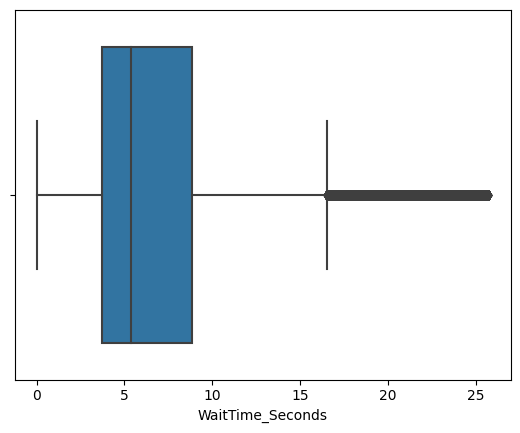

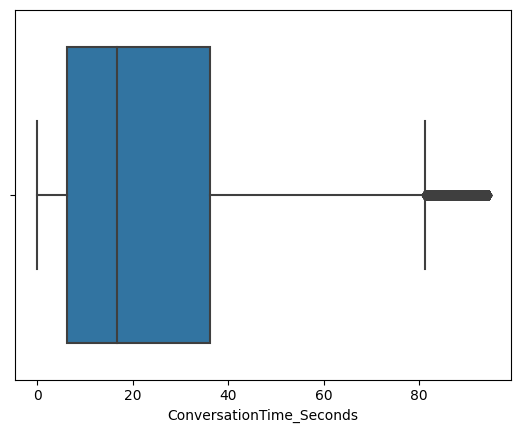

In [56]:
#boxplots to verify outliers removal
sns.boxplot(x=f_df['WaitTime_Seconds'])
plt.show()

sns.boxplot(x=f_df['ConversationTime_Seconds'])
plt.show()


c:\Users\Kays\miniconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


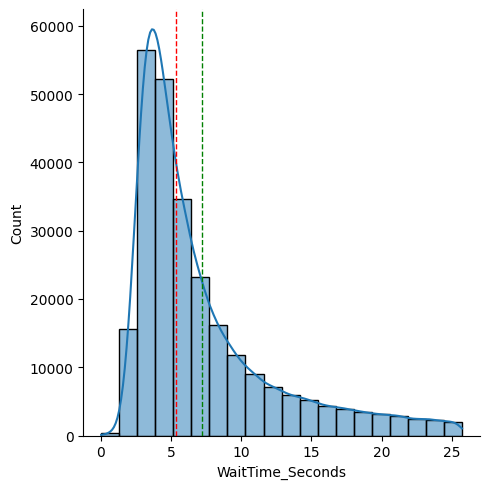

In [57]:
#CHECK distribution of WaitTime_Seconds
sns.displot(f_df['WaitTime_Seconds'], kde=True, bins=20)
#annotate median
plt.axvline(f_df['WaitTime_Seconds'].median(), color='r', linestyle='dashed', linewidth=1)
#annotate mean
plt.axvline(f_df['WaitTime_Seconds'].mean(), color='g', linestyle='dashed', linewidth=1)
plt.show()

In [58]:
f_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 262348 entries, 15332 to 450504
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   DateTime                  262348 non-null  datetime64[ns]
 1   City                      262348 non-null  category      
 2   Facility                  262348 non-null  category      
 3   Desk                      262348 non-null  object        
 4   Operator                  262348 non-null  object        
 5   WaitTime                  262348 non-null  object        
 6   ConversationTime          262318 non-null  object        
 7   Reason                    262320 non-null  string        
 8   ReasonEnteredByUser       58738 non-null   object        
 9   Flag_MissedCall           262348 non-null  object        
 10  Flag_NoCallReceived       262348 non-null  object        
 11  Flag_BarrierOpened        262348 non-null  int32         
 12  Reg

In [59]:
#check average conversation time per day without outliers
f_df['ConversationTime_Seconds'].mean()


24.239910984646343

In [60]:
df['WaitTime_Seconds'].mean()

14.124603642325146

In [61]:
#create calls per day column
f_df['Calls_per_day'] = f_df.groupby('Date')['Date'].transform('count')

#check the data
f_df.head()

,DateTime,City,Facility,Desk,Operator,WaitTime,ConversationTime,Reason,ReasonEnteredByUser,Flag_MissedCall,...,ConversationTime_Seconds,WaitTime_Seconds,Day_of_Week,Hour_of_Day,Week,Year,Operator_ID,Holiday,Device,Calls_per_day
15332,2023-11-06 16:30:49.017,Eindhoven,Eindhoven Terminal M (Meerhoven),9932,Xhadhyaene,00:00:25.703000,00:00:10.933000,Leverancier/Medewerker/ANWB,NaN,0,...,10.933,25.703,Monday,16,45,2023,24,0,UIT-3,793
15335,2023-04-11 16:15:23.137,Breda,Breda De Prins,9931,l.degier,00:00:25.697000,00:00:04.193000,No reason entered,NaN,0,...,4.193,25.697,Tuesday,16,15,2023,26,0,DL-1,667
15337,2023-11-19 16:02:18.117,Breda,Breda Chasse,9922,Imane,00:00:25.696000,00:00:08.287000,Klant was al weg,NaN,0,...,8.287,25.696,Sunday,16,46,2023,9,0,UIT-1,701
15338,2023-10-24 14:31:06.193,Oosterhout,Oosterhout Arendshof,9927,Fager Kamalizadeh,00:00:25.694000,00:00:15,Kortparkeerder,kpk niet leesbaar,0,...,15.000,25.694,Tuesday,14,43,2023,5,0,PAY-1,777
15339,2022-12-05 15:58:53.717,Veldhoven,Veldhoven De Geer,9924,Jamy,00:00:25.694000,00:00:01.920000,No reason entered,NaN,0,...,1.920,25.694,Monday,15,49,2022,12,1,DL-3,635


In [62]:
#calculate calls per day per facility
calls_per_day_facility = f_df.groupby(['Facility', 'Date'])['Facility'].count().reset_index(name='CallCount')

# Display the top three facilities with the highest average calls per day 
top_facilities = calls_per_day_facility.groupby('Facility')['CallCount'].mean().sort_values(ascending=False).head(5)
print(top_facilities)


Facility
Eindhoven Terminal M (Meerhoven)    32.378747
Amsterdam Houthaven                 30.332425
Breda De Barones                    26.836512
Amsterdam De Overkant               23.645777
Breda De Prins                      22.738420
Name: CallCount, dtype: float64


In [63]:
# Group by Operator_ID and Hour_of_Day, then calculate the average wait time
avg_wait_per_hour_operator = f_df.groupby(['Operator_ID', 'Hour_of_Day'])['WaitTime_Seconds'].mean().reset_index(name='AverageWaitTime')

# Calculate the number of days
num_days = f_df['Date'].nunique()

# Calculate the average wait time per hour for each operator
# The number of days is used to average over different days
avg_wait_per_hour_operator['AverageWaitTimePerDay'] = avg_wait_per_hour_operator['AverageWaitTime'] / num_days
avg_wait_per_hour_operator = avg_wait_per_hour_operator[['Operator_ID', 'Hour_of_Day', 'AverageWaitTimePerDay']]

# Now, avg_wait_per_hour_operator contains the average wait time per day for each hour for each operator


In [64]:
 # Loop through each facility and plot its daily call count 

 #for facility in calls_per_day_facility['Facility'].unique(): 

#    # subset = calls_per_day_facility[calls_per_day_facility['Facility'] == facility] 
#     plt.figure(figsize=(15, 5)) 
#     plt.plot(pd.to_datetime(subset['Date']), subset['CallCount'], label=facility) 
#     plt.title(f'Call Count per Day for {facility}') 
#     plt.xlabel('Date') 
#     plt.ylabel('Number of Calls')
#     plt.legend() 
#     plt.show()

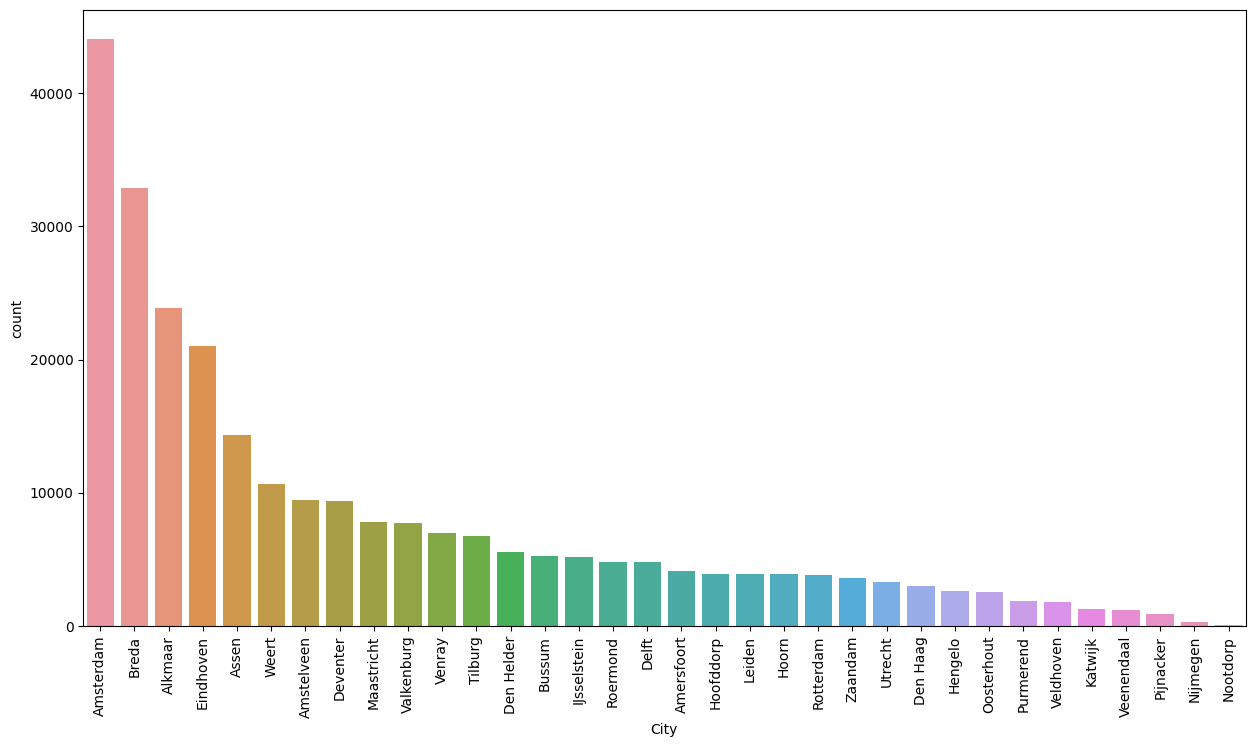

In [65]:
#eda

#check count of reported issues per city
plt.figure(figsize=(15, 8))
sns.countplot(x='City', data=f_df, order=f_df['City'].value_counts().index)
plt.xticks(rotation=90)
plt.show()


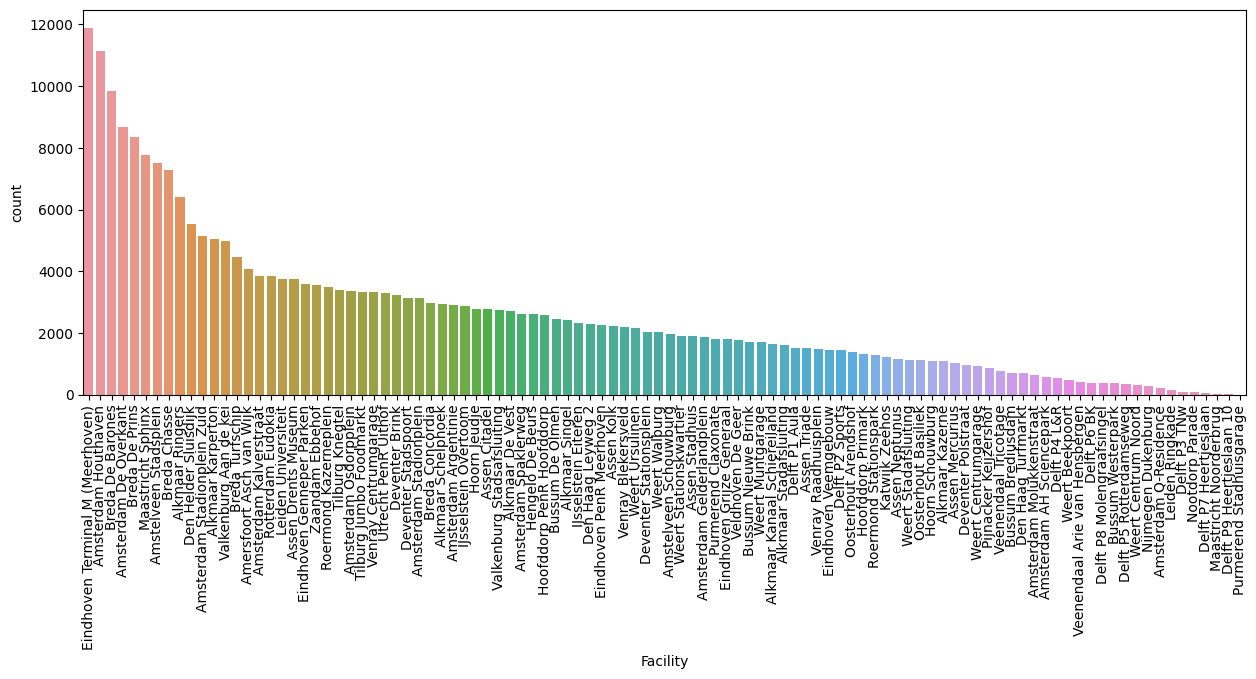

In [66]:
#more eda, check count of reported issues per facility, ordered by count on the x axis



plt.figure(figsize=(15, 5))
#plot count on x axis
sns.countplot(x='Facility', data=f_df, order=f_df['Facility'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 349423 entries, 0 to 451677
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   DateTime                  349423 non-null  datetime64[ns]
 1   City                      349423 non-null  object        
 2   Facility                  349423 non-null  object        
 3   Desk                      349423 non-null  object        
 4   Operator                  349423 non-null  object        
 5   WaitTime                  325726 non-null  object        
 6   ConversationTime          349297 non-null  object        
 7   Reason                    349300 non-null  object        
 8   ReasonEnteredByUser       83551 non-null   object        
 9   Flag_MissedCall           349423 non-null  object        
 10  Flag_NoCallReceived       349423 non-null  object        
 11  Flag_BarrierOpened        121580 non-null  object        
 12  Region 

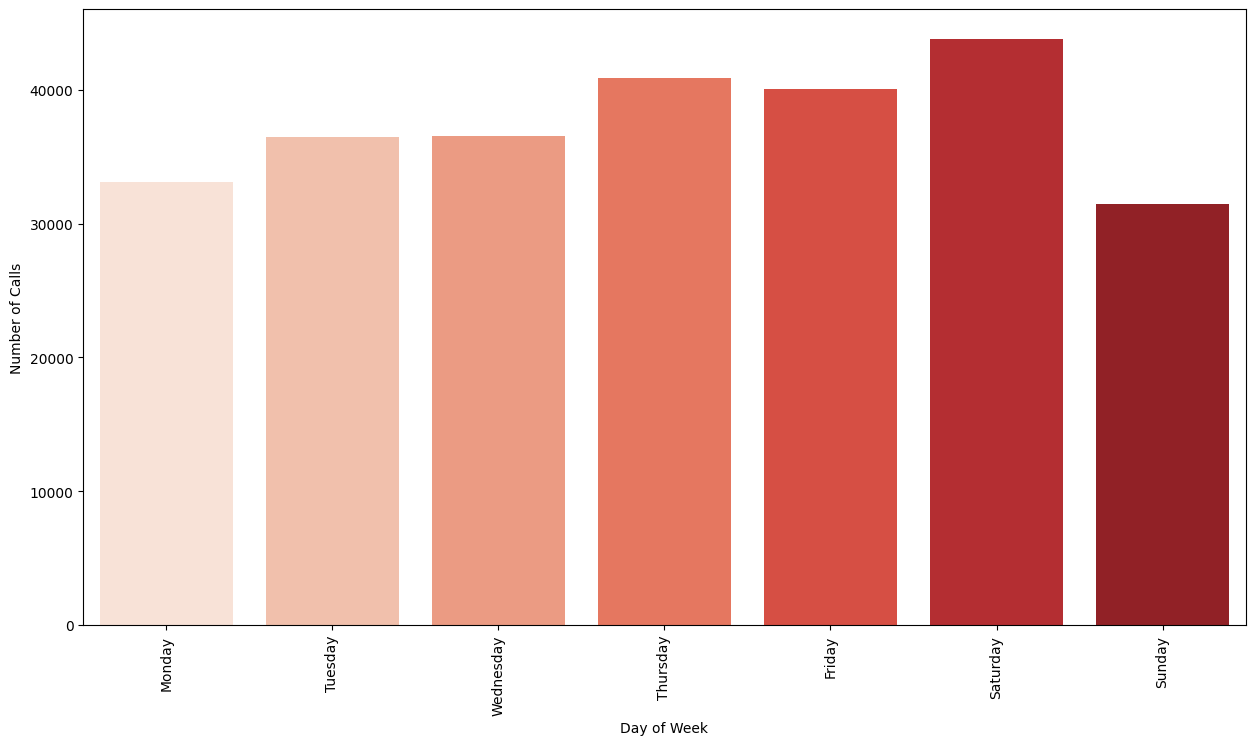

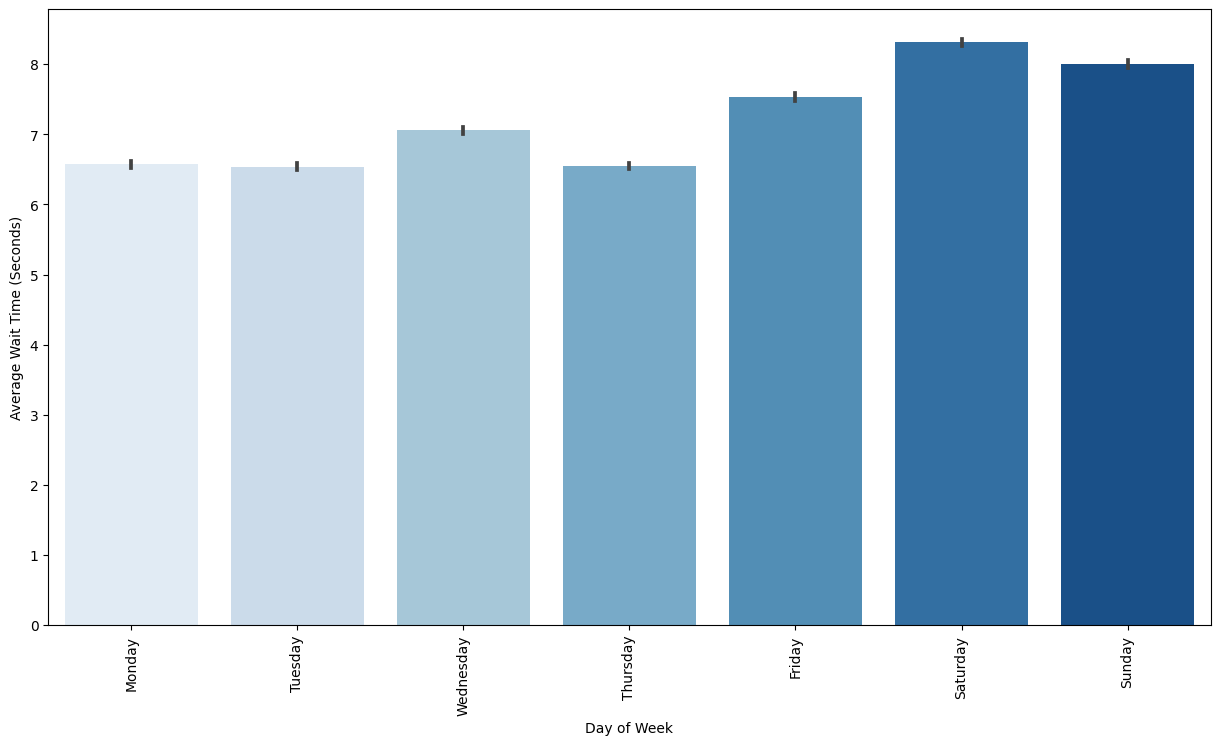

In [68]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
#check count of reported issues per day of week
plt.figure(figsize=(15, 8))
sns.countplot(x='Day_of_Week', data=f_df, order=order, palette='Reds')
plt.xticks(rotation=90)
plt.xlabel('Day of Week')
plt.ylabel('Number of Calls')
plt.show()

#more eda, AVG wait time per day of week, ordered monday to sunday
plt.figure(figsize=(15, 8))
sns.barplot(x='Day_of_Week', y='WaitTime_Seconds', data=f_df, order=order, palette='Blues')
plt.xticks(rotation=90)
plt.xlabel('Day of Week')
plt.ylabel('Average Wait Time (Seconds)')
plt.show()




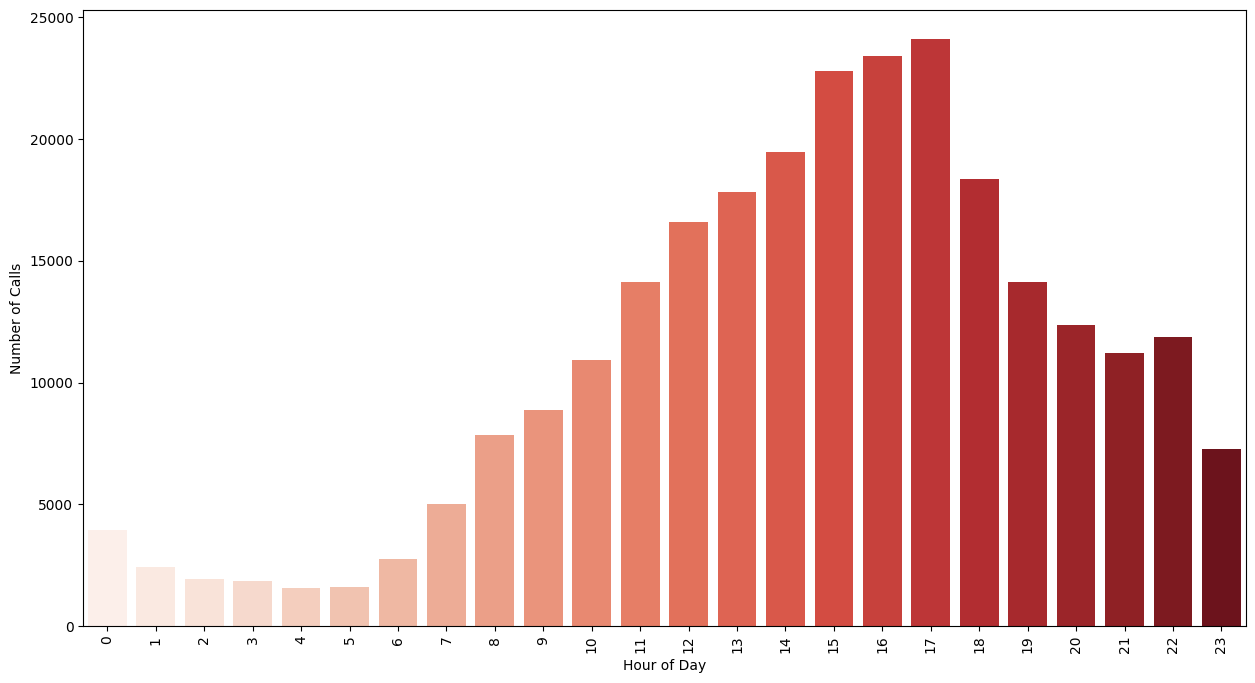

In [69]:
#more eda
#check count of reported issues per hour of day
plt.figure(figsize=(15, 8))
sns.countplot(x='Hour_of_Day', data=f_df,palette='Reds')
plt.xticks(rotation=90)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Calls')
plt.show()


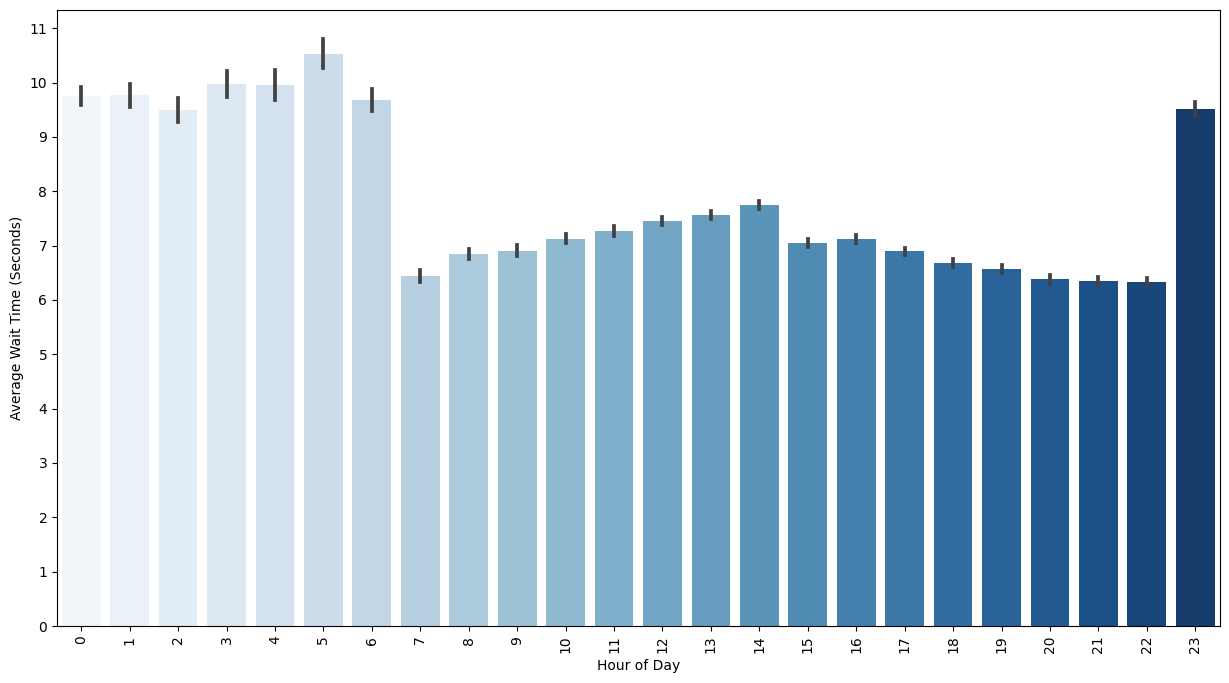

In [70]:

#more eda, AVG wait time per hour of day , ordered starting from 7am to 7 am
plt.figure(figsize=(15, 8))
sns.barplot(x='Hour_of_Day', y='WaitTime_Seconds', data=f_df, palette='Blues')
#yticks as seconds
plt.yticks(np.arange(0, 12, 1))
plt.xticks(rotation=90)
plt.xlabel('Hour of Day')
plt.ylabel('Average Wait Time (Seconds)')
plt.show()


c:\Users\Kays\miniconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


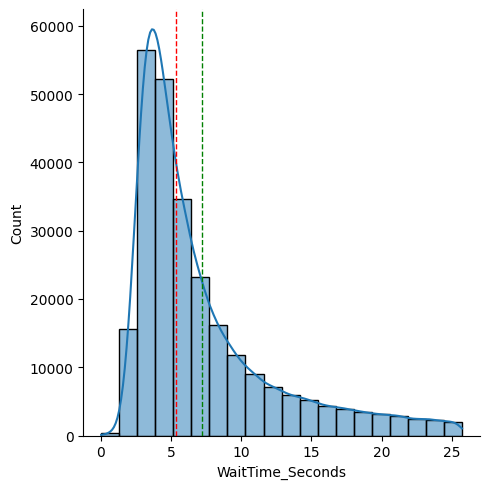

c:\Users\Kays\miniconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


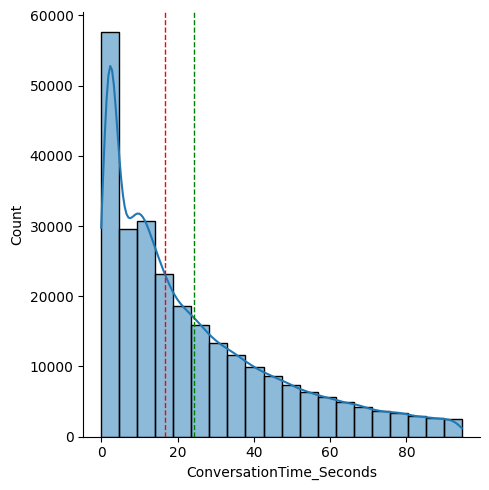

c:\Users\Kays\miniconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


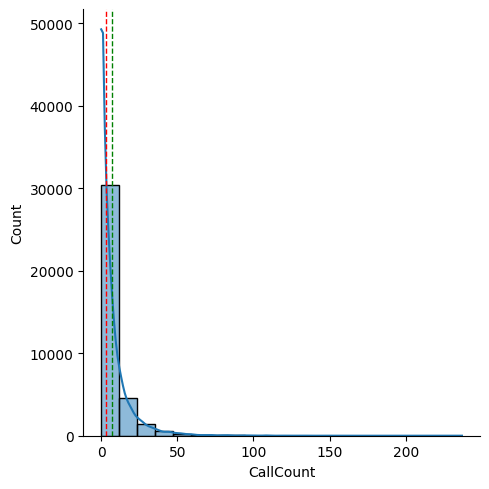

In [71]:
#selecting a model
#check the distribution of the target variable

#check distribution of WaitTime_Seconds
sns.displot(f_df['WaitTime_Seconds'], kde=True, bins=20)
#annotate median
plt.axvline(f_df['WaitTime_Seconds'].median(), color='r', linestyle='dashed', linewidth=1)
#annotate mean
plt.axvline(f_df['WaitTime_Seconds'].mean(), color='g', linestyle='dashed', linewidth=1)
plt.show()

#check distribution of ConversationTime_Seconds
sns.displot(f_df['ConversationTime_Seconds'], kde=True, bins=20)
#annotate median
plt.axvline(f_df['ConversationTime_Seconds'].median(), color='r', linestyle='dashed', linewidth=1)
#annotate mean
plt.axvline(f_df['ConversationTime_Seconds'].mean(), color='g', linestyle='dashed', linewidth=1)
plt.show()


#more target variables could be : 
#- wait time per day of week
#- wait time per hour of day
#- wait time per facility
#- wait time per city
#- wait time per operator
#- wait time per reason
#- wait time per device

# or we could predict the number of calls per day per facility by using the date as a target variable
#for example we could predict the number of calls per day for the next 30 days for each facility

#check distribution of calls per day per facility
sns.displot(calls_per_day_facility['CallCount'], kde=True, bins=20)
#annotate median
plt.axvline(calls_per_day_facility['CallCount'].median(), color='r', linestyle='dashed', linewidth=1)
#annotate mean
plt.axvline(calls_per_day_facility['CallCount'].mean(), color='g', linestyle='dashed', linewidth=1)
plt.show()



In [72]:
f_df.head()

,DateTime,City,Facility,Desk,Operator,WaitTime,ConversationTime,Reason,ReasonEnteredByUser,Flag_MissedCall,...,ConversationTime_Seconds,WaitTime_Seconds,Day_of_Week,Hour_of_Day,Week,Year,Operator_ID,Holiday,Device,Calls_per_day
15332,2023-11-06 16:30:49.017,Eindhoven,Eindhoven Terminal M (Meerhoven),9932,Xhadhyaene,00:00:25.703000,00:00:10.933000,Leverancier/Medewerker/ANWB,NaN,0,...,10.933,25.703,Monday,16,45,2023,24,0,UIT-3,793
15335,2023-04-11 16:15:23.137,Breda,Breda De Prins,9931,l.degier,00:00:25.697000,00:00:04.193000,No reason entered,NaN,0,...,4.193,25.697,Tuesday,16,15,2023,26,0,DL-1,667
15337,2023-11-19 16:02:18.117,Breda,Breda Chasse,9922,Imane,00:00:25.696000,00:00:08.287000,Klant was al weg,NaN,0,...,8.287,25.696,Sunday,16,46,2023,9,0,UIT-1,701
15338,2023-10-24 14:31:06.193,Oosterhout,Oosterhout Arendshof,9927,Fager Kamalizadeh,00:00:25.694000,00:00:15,Kortparkeerder,kpk niet leesbaar,0,...,15.000,25.694,Tuesday,14,43,2023,5,0,PAY-1,777
15339,2022-12-05 15:58:53.717,Veldhoven,Veldhoven De Geer,9924,Jamy,00:00:25.694000,00:00:01.920000,No reason entered,NaN,0,...,1.920,25.694,Monday,15,49,2022,12,1,DL-3,635


In [73]:
# Created flag column for the devices  
f_df['Device_1'] = f_df['Device'].astype(str) 


def check_exit(value): 
    keywords = ['UIT', 'Exit', 'Uitrit'] 
    return any(keyword in value for keyword in keywords) 

def check_entry(value): 
    keywords = ['IN', 'Entry', 'ENTREE', 'Inrit'] 
    return any(keyword in value for keyword in keywords) 

def check_atm(value): 
    keywords = ['BA', 'Kassa'] # looks for keyword in string value
    return any(keyword in value for keyword in keywords) 

def check_gate(value): 
    keywords = ['SG', 'GATE'] 
    return any(keyword in value for keyword in keywords) 

def check_door(value): 
    keywords = ['Door', 'Deur', 'DL'] 
    return any(keyword in value for keyword in keywords) 

# Apply the functions 
f_df['Exit'] = f_df['Device_1'].apply(check_exit).astype(int) 
f_df['Entry'] = f_df['Device_1'].apply(check_entry).astype(int) 
f_df['Pay'] = f_df['Device_1'].apply(check_atm).astype(int) 
f_df['Gate'] = f_df['Device_1'].apply(check_gate).astype(int) 
f_df['Door'] = f_df['Device_1'].apply(check_door).astype(int) 

 

In [74]:
#check results
f_df.head()

,DateTime,City,Facility,Desk,Operator,WaitTime,ConversationTime,Reason,ReasonEnteredByUser,Flag_MissedCall,...,Operator_ID,Holiday,Device,Calls_per_day,Device_1,Exit,Entry,Pay,Gate,Door
15332,2023-11-06 16:30:49.017,Eindhoven,Eindhoven Terminal M (Meerhoven),9932,Xhadhyaene,00:00:25.703000,00:00:10.933000,Leverancier/Medewerker/ANWB,NaN,0,...,24,0,UIT-3,793,UIT-3,1,0,0,0,0
15335,2023-04-11 16:15:23.137,Breda,Breda De Prins,9931,l.degier,00:00:25.697000,00:00:04.193000,No reason entered,NaN,0,...,26,0,DL-1,667,DL-1,0,0,0,0,1
15337,2023-11-19 16:02:18.117,Breda,Breda Chasse,9922,Imane,00:00:25.696000,00:00:08.287000,Klant was al weg,NaN,0,...,9,0,UIT-1,701,UIT-1,1,0,0,0,0
15338,2023-10-24 14:31:06.193,Oosterhout,Oosterhout Arendshof,9927,Fager Kamalizadeh,00:00:25.694000,00:00:15,Kortparkeerder,kpk niet leesbaar,0,...,5,0,PAY-1,777,PAY-1,0,0,0,0,0
15339,2022-12-05 15:58:53.717,Veldhoven,Veldhoven De Geer,9924,Jamy,00:00:25.694000,00:00:01.920000,No reason entered,NaN,0,...,12,1,DL-3,635,DL-3,0,0,0,0,1


In [75]:


#Count reasons
f_df['Reason'].value_counts()


Reason
No reason entered              171852
Kortparkeerder                  61352
Klant was al weg                20901
Overige                          3554
Abonnementhouder                 2572
Leverancier/Medewerker/ANWB      2089
Name: count, dtype: Int64

In [76]:
f_df['Reason'].unique()

<StringArray>
['Leverancier/Medewerker/ANWB',           'No reason entered',
            'Klant was al weg',              'Kortparkeerder',
                     'Overige',                          <NA>,
            'Abonnementhouder']
Length: 7, dtype: string

In [77]:


#turn NA to No reason entered
f_df['Reason'] = f_df['Reason'].fillna('No reason entered')



In [78]:
##Seasonal trends for when its summer and winter 
f_df['IsSummer'] = f_df['DateTime'].dt.month.isin([6, 7, 8]).astype(int)
f_df['IsSpring'] = f_df['DateTime'].dt.month.isin([3, 4, 5]).astype(int)
f_df['IsAutumn'] = f_df['DateTime'].dt.month.isin([9, 10, 11]).astype(int)
f_df['IsWinter'] = f_df['DateTime'].dt.month.isin([12, 1, 2]).astype(int)

In [79]:
f_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 262348 entries, 15332 to 450504
Data columns (total 40 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   DateTime                  262348 non-null  datetime64[ns]
 1   City                      262348 non-null  category      
 2   Facility                  262348 non-null  category      
 3   Desk                      262348 non-null  object        
 4   Operator                  262348 non-null  object        
 5   WaitTime                  262348 non-null  object        
 6   ConversationTime          262318 non-null  object        
 7   Reason                    262348 non-null  string        
 8   ReasonEnteredByUser       58738 non-null   object        
 9   Flag_MissedCall           262348 non-null  object        
 10  Flag_NoCallReceived       262348 non-null  object        
 11  Flag_BarrierOpened        262348 non-null  int32         
 12  Reg

In [80]:
# Group by year and week and count the number of calls
weekly_call_counts = f_df.groupby(['Year', 'Week']).size().reset_index(name='CallCountPerWeek')

# Display the first few rows
weekly_call_counts.head()

#merge with f_df
f_df = f_df.merge(weekly_call_counts, on=['Year', 'Week'], how='left')

# Display the first few rows
f_df.head()


,DateTime,City,Facility,Desk,Operator,WaitTime,ConversationTime,Reason,ReasonEnteredByUser,Flag_MissedCall,...,Exit,Entry,Pay,Gate,Door,IsSummer,IsSpring,IsAutumn,IsWinter,CallCountPerWeek
0,2023-11-06 16:30:49.017,Eindhoven,Eindhoven Terminal M (Meerhoven),9932,Xhadhyaene,00:00:25.703000,00:00:10.933000,Leverancier/Medewerker/ANWB,NaN,0,...,1,0,0,0,0,0,0,1,0,5852
1,2023-04-11 16:15:23.137,Breda,Breda De Prins,9931,l.degier,00:00:25.697000,00:00:04.193000,No reason entered,NaN,0,...,0,0,0,0,1,0,1,0,0,4298
2,2023-11-19 16:02:18.117,Breda,Breda Chasse,9922,Imane,00:00:25.696000,00:00:08.287000,Klant was al weg,NaN,0,...,1,0,0,0,0,0,0,1,0,5350
3,2023-10-24 14:31:06.193,Oosterhout,Oosterhout Arendshof,9927,Fager Kamalizadeh,00:00:25.694000,00:00:15,Kortparkeerder,kpk niet leesbaar,0,...,0,0,0,0,0,0,0,1,0,6716
4,2022-12-05 15:58:53.717,Veldhoven,Veldhoven De Geer,9924,Jamy,00:00:25.694000,00:00:01.920000,No reason entered,NaN,0,...,0,0,0,0,1,0,0,0,1,4755


In [81]:
f_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262348 entries, 0 to 262347
Data columns (total 41 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   DateTime                  262348 non-null  datetime64[ns]
 1   City                      262348 non-null  category      
 2   Facility                  262348 non-null  category      
 3   Desk                      262348 non-null  object        
 4   Operator                  262348 non-null  object        
 5   WaitTime                  262348 non-null  object        
 6   ConversationTime          262318 non-null  object        
 7   Reason                    262348 non-null  string        
 8   ReasonEnteredByUser       58738 non-null   object        
 9   Flag_MissedCall           262348 non-null  object        
 10  Flag_NoCallReceived       262348 non-null  object        
 11  Flag_BarrierOpened        262348 non-null  int32         
 12  Re

In [82]:
#created a column Is_weekend to find out if calls were made in the weekends 
## Map day names to weekend or not 
weekend_mapping = {'Monday': False, 'Tuesday': False, 'Wednesday': False, 'Thursday': False, 'Friday': False, 'Saturday': True, 'Sunday': True} 
f_df['IsWeekend'] = f_df['Day_of_Week'].map(weekend_mapping) 

#turn nan to 0
f_df['IsWeekend'] = f_df['IsWeekend'].fillna(0)

In [83]:

#check for nulls
f_df.isnull().sum()

#drop nulls in conversation time
f_df = f_df.dropna(subset=['ConversationTime'])

In [84]:

# Calculate mean calls per hour
mean_calls_per_hour = f_df.groupby('Hour_of_Day').size().mean()

# Identify busy hours by comparing each hour's call count with the mean
busy_hours = f_df.groupby('Hour_of_Day').size()[f_df.groupby('Hour_of_Day').size() > mean_calls_per_hour].index

# Create a binary feature for busy hour
f_df['IsBusyHour'] = f_df['Hour_of_Day'].apply(lambda x: 1 if x in busy_hours else 0)

# For lagged features, let's say we want a 1-hour lag
f_df['LaggedBusyHour'] = f_df['IsBusyHour'].shift(1).fillna(method='bfill')

# Create a lagged column for the call count.
# We'll use a 1-hour lag again
f_df['LaggedCallCount'] = f_df['CallCountPerWeek'].shift(1).fillna(method='bfill')



In [85]:

print(f_df.head())

                 DateTime        City                          Facility  Desk  \
0 2023-11-06 16:30:49.017   Eindhoven  Eindhoven Terminal M (Meerhoven)  9932   
1 2023-04-11 16:15:23.137       Breda                    Breda De Prins  9931   
2 2023-11-19 16:02:18.117       Breda                      Breda Chasse  9922   
3 2023-10-24 14:31:06.193  Oosterhout              Oosterhout Arendshof  9927   
4 2022-12-05 15:58:53.717   Veldhoven                 Veldhoven De Geer  9924   

            Operator         WaitTime ConversationTime  \
0         Xhadhyaene  00:00:25.703000  00:00:10.933000   
1           l.degier  00:00:25.697000  00:00:04.193000   
2              Imane  00:00:25.696000  00:00:08.287000   
3  Fager Kamalizadeh  00:00:25.694000         00:00:15   
4               Jamy  00:00:25.694000  00:00:01.920000   

                        Reason ReasonEnteredByUser Flag_MissedCall  ... Door  \
0  Leverancier/Medewerker/ANWB                 NaN               0  ...    0   
1   

In [86]:
#check if is busy hour makes sense 
f_df[f_df['IsBusyHour'] == 1]['Hour_of_Day'].value_counts()

Hour_of_Day
17    24099
16    23405
15    22811
14    19449
18    18379
13    17810
12    16591
11    14148
19    14115
20    12379
22    11891
21    11197
10    10932
0         0
1         0
9         0
8         0
7         0
6         0
5         0
4         0
3         0
2         0
23        0
Name: count, dtype: int64

In [87]:
# Calculate the median
median_calls_per_day = f_df['Calls_per_day'].median()
median_call_count_per_week = f_df['CallCountPerWeek'].median()

# Bin the Calls_per_day column
f_df['Calls_per_day_Bin'] = pd.cut(f_df['Calls_per_day'], 
                                    bins=[-np.inf, median_calls_per_day, np.inf], 
                                    labels=['Low_Call_Day', 'High_Call_Day'])

# Bin the CallCountPerWeek column
f_df['CallCountPerWeek_Bin'] = pd.cut(f_df['CallCountPerWeek'], 
                                       bins=[-np.inf, median_call_count_per_week, np.inf], 
                                       labels=['Low_Call_Week', 'High_Call_Week'])

# Create flags for Calls_per_day
f_df['Low_Call_Day_Flag'] = np.where(f_df['Calls_per_day_Bin'] == 'Low_Call_Day', 1, 0)
f_df['High_Call_Day_Flag'] = np.where(f_df['Calls_per_day_Bin'] == 'High_Call_Day', 1, 0)

# Create flags for CallCountPerWeek
f_df['Low_Call_Week_Flag'] = np.where(f_df['CallCountPerWeek_Bin'] == 'Low_Call_Week', 1, 0)
f_df['High_Call_Week_Flag'] = np.where(f_df['CallCountPerWeek_Bin'] == 'High_Call_Week', 1, 0)


In [88]:
# Create the ratio features
small_value = 0.001
f_df['CallDurationRatio'] = f_df['WaitTime_Seconds'] / (f_df['ConversationTime_Seconds'] + small_value)
f_df['PopulationCarRatio'] = f_df['Population_Dens'] / (f_df['cars_per_region'] + small_value)


In [89]:


#turn nan to -
f_df['ReasonEnteredByUser'] = f_df['ReasonEnteredByUser'].fillna('-')

In [90]:
f_df.head()

,DateTime,City,Facility,Desk,Operator,WaitTime,ConversationTime,Reason,ReasonEnteredByUser,Flag_MissedCall,...,LaggedBusyHour,LaggedCallCount,Calls_per_day_Bin,CallCountPerWeek_Bin,Low_Call_Day_Flag,High_Call_Day_Flag,Low_Call_Week_Flag,High_Call_Week_Flag,CallDurationRatio,PopulationCarRatio
0,2023-11-06 16:30:49.017,Eindhoven,Eindhoven Terminal M (Meerhoven),9932,Xhadhyaene,00:00:25.703000,00:00:10.933000,Leverancier/Medewerker/ANWB,-,0,...,1.0,5852.0,High_Call_Day,High_Call_Week,0,1,0,1,2.350741,0.000364
1,2023-04-11 16:15:23.137,Breda,Breda De Prins,9931,l.degier,00:00:25.697000,00:00:04.193000,No reason entered,-,0,...,1.0,5852.0,Low_Call_Day,Low_Call_Week,1,0,1,0,6.127086,0.000364
2,2023-11-19 16:02:18.117,Breda,Breda Chasse,9922,Imane,00:00:25.696000,00:00:08.287000,Klant was al weg,-,0,...,1.0,4298.0,Low_Call_Day,High_Call_Week,1,0,0,1,3.100386,0.000364
3,2023-10-24 14:31:06.193,Oosterhout,Oosterhout Arendshof,9927,Fager Kamalizadeh,00:00:25.694000,00:00:15,Kortparkeerder,kpk niet leesbaar,0,...,1.0,5350.0,High_Call_Day,High_Call_Week,0,1,0,1,1.712819,0.000364
4,2022-12-05 15:58:53.717,Veldhoven,Veldhoven De Geer,9924,Jamy,00:00:25.694000,00:00:01.920000,No reason entered,-,0,...,1.0,6716.0,Low_Call_Day,Low_Call_Week,1,0,1,0,13.375325,0.000364


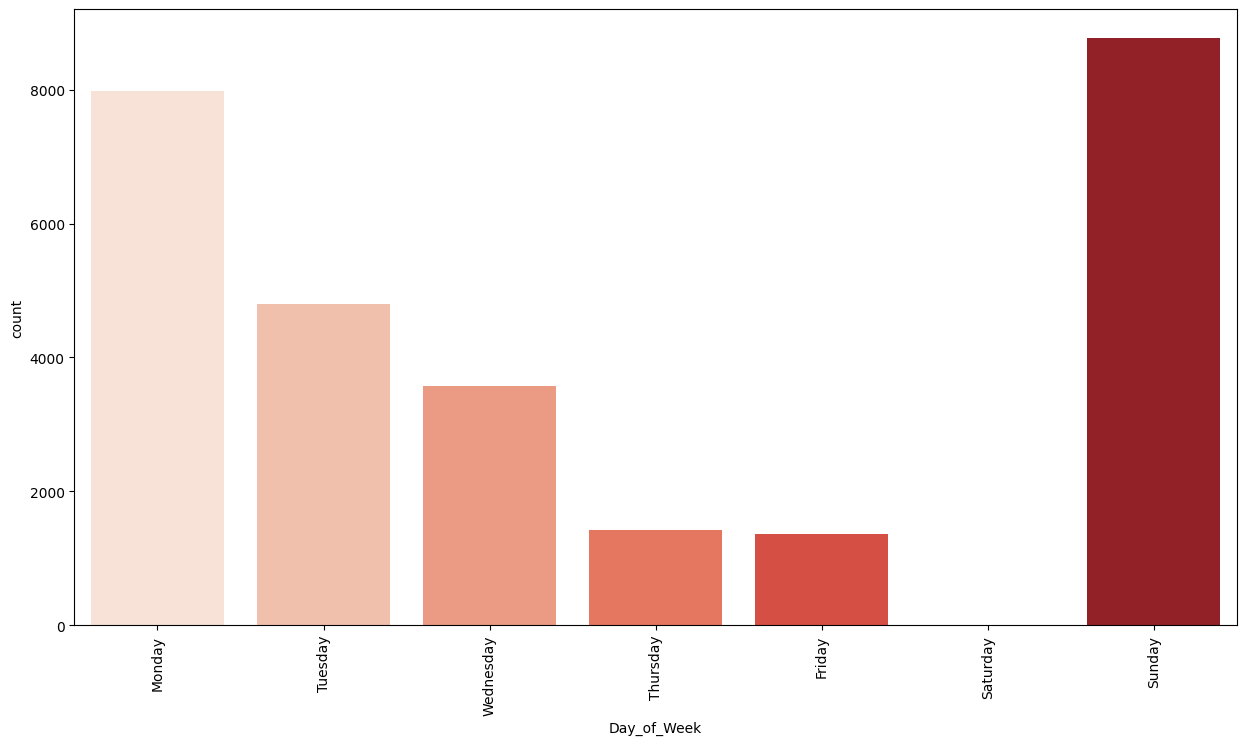

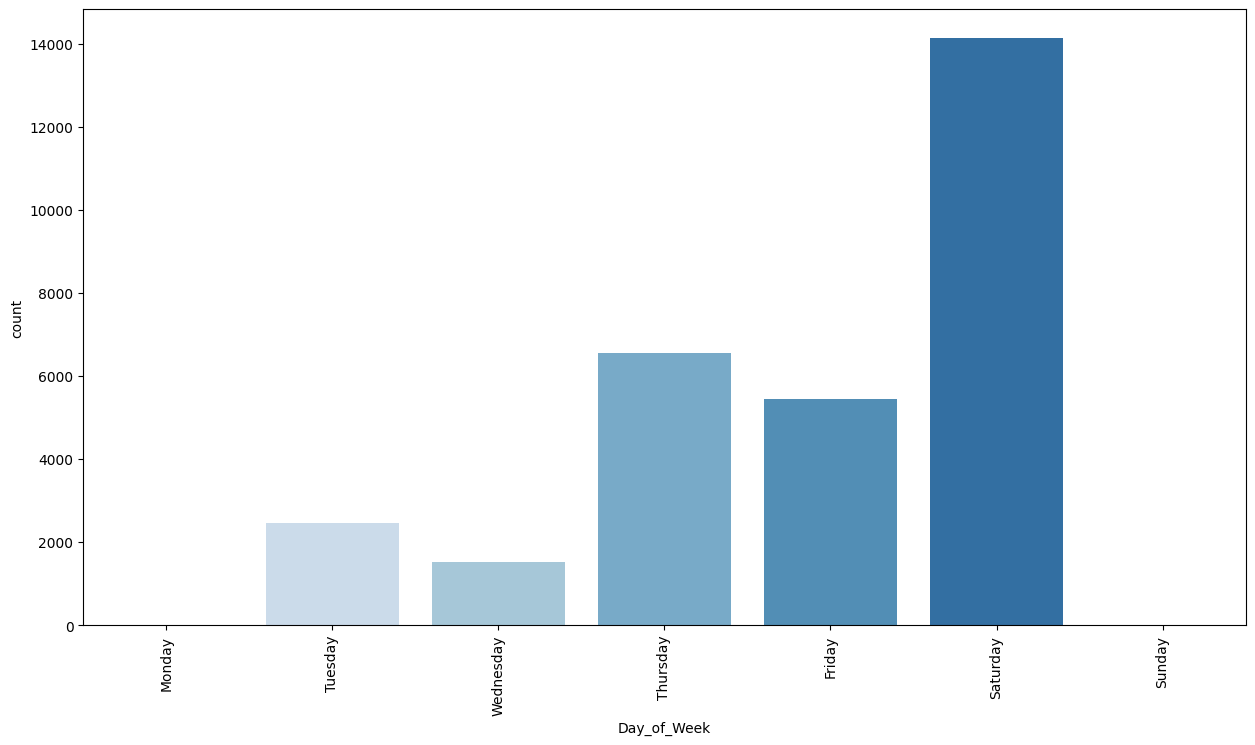

In [91]:
#check what days are the ones most often when it is a high call week, but low call day
f_df[(f_df['High_Call_Week_Flag'] == 1) & (f_df['Low_Call_Day_Flag'] == 1)]['Day_of_Week'].value_counts()

#visualize with days of week
order= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(15, 8))
sns.countplot(x='Day_of_Week', data=f_df[(f_df['High_Call_Week_Flag'] == 1) & (f_df['Low_Call_Day_Flag'] == 1)], order=order, palette='Reds')
plt.xticks(rotation=90)
plt.show()

#check what days are the ones most often when it is a low call week, but high call day
f_df[(f_df['Low_Call_Week_Flag'] == 1) & (f_df['High_Call_Day_Flag'] == 1)]['Day_of_Week'].value_counts()

#visualize with days of week
plt.figure(figsize=(15, 8))
sns.countplot(x='Day_of_Week', data=f_df[(f_df['Low_Call_Week_Flag'] == 1) & (f_df['High_Call_Day_Flag'] == 1)], order=order, palette='Blues')
plt.xticks(rotation=90)
plt.show()


In [92]:
#drop ReasonEnteredByUser and Operator columns
f_df = f_df.drop(['ReasonEnteredByUser'], axis=1)
f_df = f_df.drop(['Operator'], axis=1)

#create month column
f_df['Month'] = f_df['DateTime'].dt.month


In [93]:
f_df.columns

Index(['DateTime', 'City', 'Facility', 'Desk', 'WaitTime', 'ConversationTime',
       'Reason', 'Flag_MissedCall', 'Flag_NoCallReceived',
       'Flag_BarrierOpened', 'Region', 'ID', 'RegioS', 'Population_Dens',
       'DistanceTravelled_5', 'cars_per_region', 'cars_per_region_1000',
       'Date', 'ConversationTime_Seconds', 'WaitTime_Seconds', 'Day_of_Week',
       'Hour_of_Day', 'Week', 'Year', 'Operator_ID', 'Holiday', 'Device',
       'Calls_per_day', 'Device_1', 'Exit', 'Entry', 'Pay', 'Gate', 'Door',
       'IsSummer', 'IsSpring', 'IsAutumn', 'IsWinter', 'CallCountPerWeek',
       'IsWeekend', 'IsBusyHour', 'LaggedBusyHour', 'LaggedCallCount',
       'Calls_per_day_Bin', 'CallCountPerWeek_Bin', 'Low_Call_Day_Flag',
       'High_Call_Day_Flag', 'Low_Call_Week_Flag', 'High_Call_Week_Flag',
       'CallDurationRatio', 'PopulationCarRatio', 'Month'],
      dtype='object')

In [94]:
# check total nr of times each device was used ine ach facility
device_usage_per_facility = f_df.groupby('Facility').agg({
    'Gate': 'sum',
    'Entry': 'sum',
    'Exit': 'sum',
    'Pay': 'sum',
    'Door': 'sum'
}).reset_index()


# Display the first few rows
device_usage_per_facility.head()

,Facility,Gate,Entry,Exit,Pay,Door
0,Alkmaar De Vest,0,1368,890,264,0
1,Alkmaar Kanaal Schiereiland,0,341,928,362,0
2,Alkmaar Karperton,0,898,2519,1380,260
3,Alkmaar Kazerne,0,70,311,0,671
4,Alkmaar Ringers,0,716,4061,1639,0


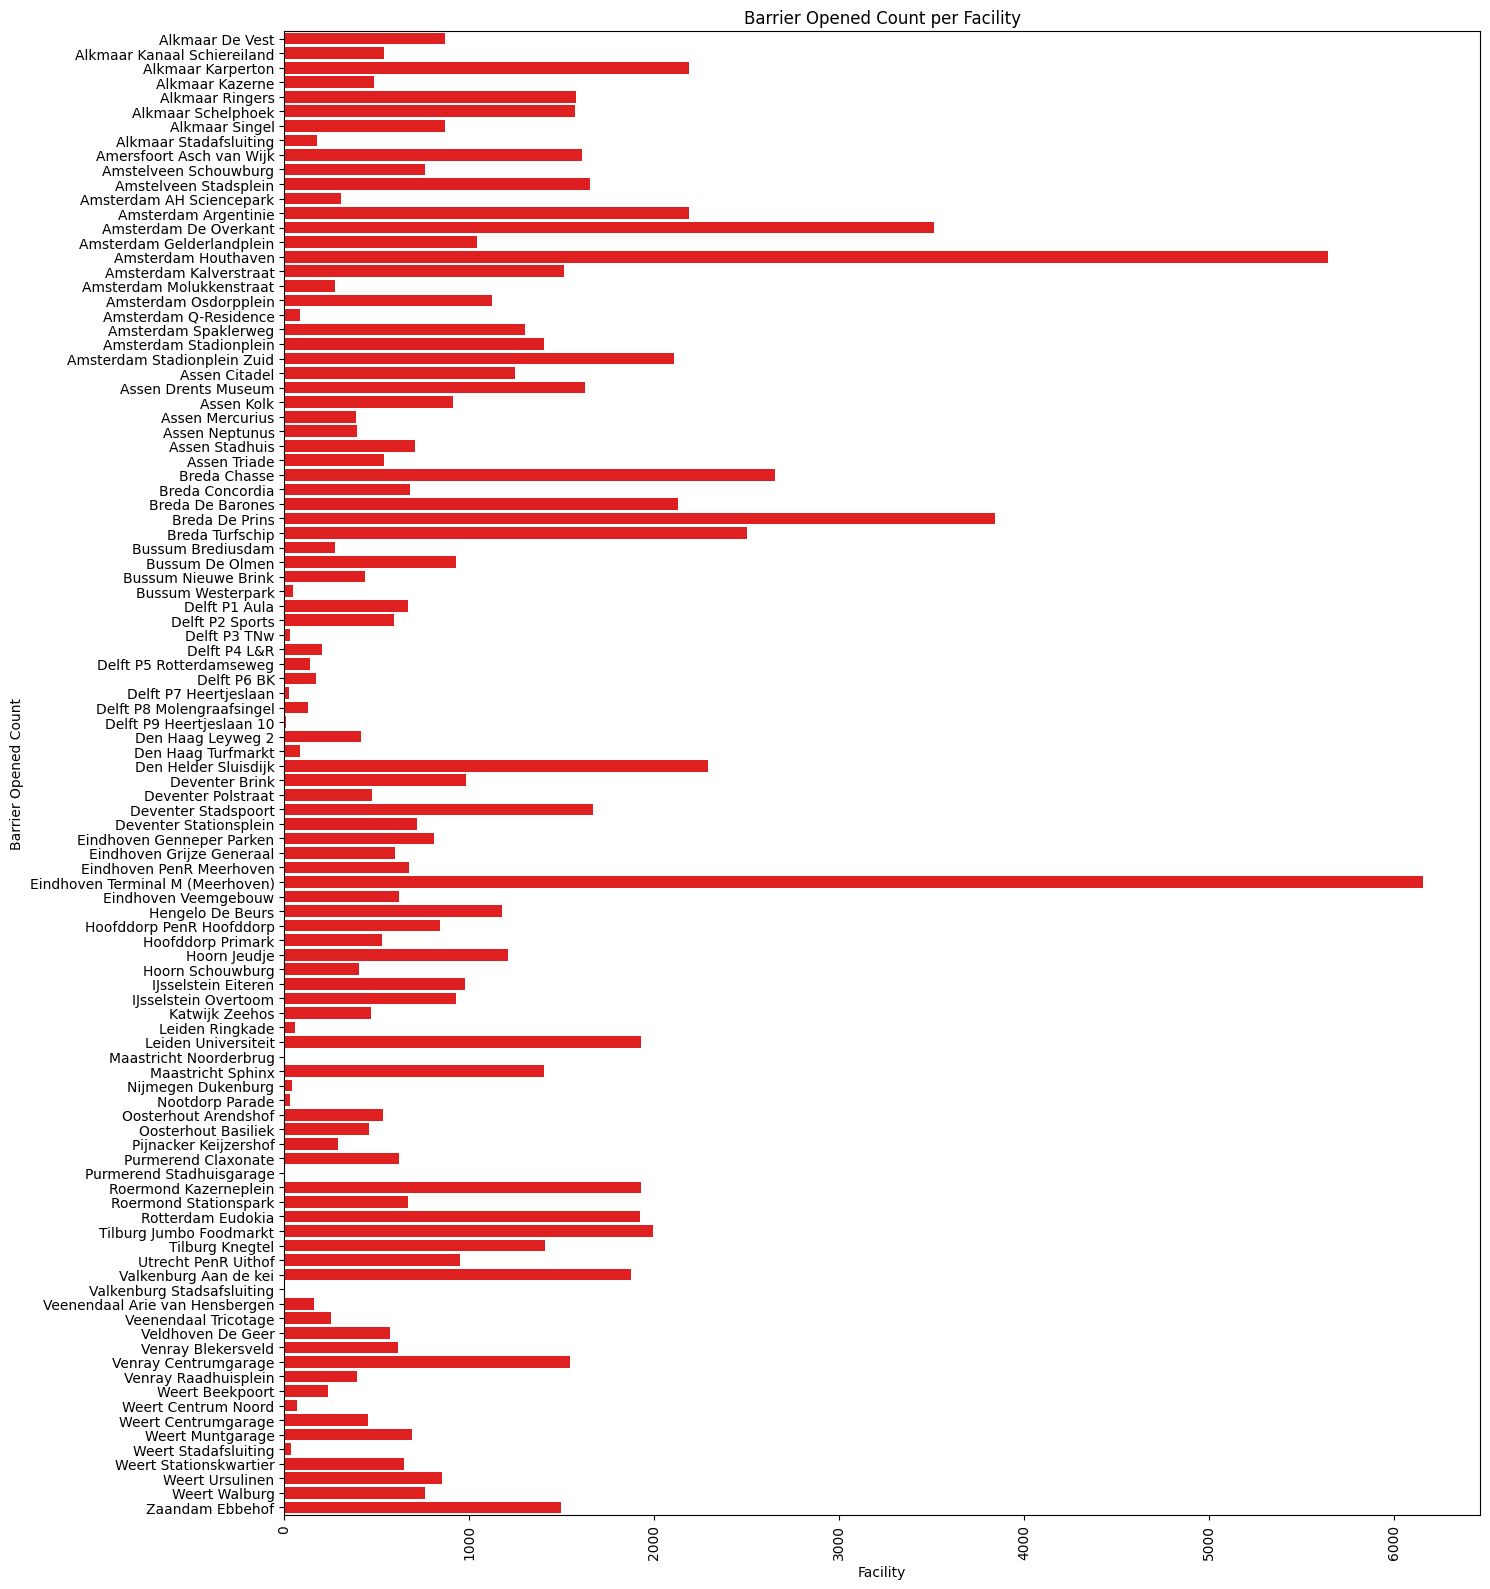

In [98]:
barrier_opened_count = f_df.groupby('Facility')['Flag_BarrierOpened'].sum().reset_index(name='BarrierOpenedCount')
device_usage_df = device_usage_per_facility.merge(barrier_opened_count, on='Facility', how='left')

# Visualize results
plt.figure(figsize=(15, 16))
sns.barplot(x='BarrierOpenedCount', y='Facility', data=device_usage_df, color='red')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
# Set labels and title
plt.xlabel('Facility')
plt.ylabel('Barrier Opened Count')
plt.title('Barrier Opened Count per Facility')
plt.tight_layout()

# Display the plot
plt.show()

In [96]:
#merge with f_df
f_df = f_df.merge(device_usage_df, on='Facility', how='left')




In [97]:

f_df.columns

Index(['DateTime', 'City', 'Facility', 'Desk', 'WaitTime', 'ConversationTime',
       'Reason', 'Flag_MissedCall', 'Flag_NoCallReceived',
       'Flag_BarrierOpened', 'Region', 'ID', 'RegioS', 'Population_Dens',
       'DistanceTravelled_5', 'cars_per_region', 'cars_per_region_1000',
       'Date', 'ConversationTime_Seconds', 'WaitTime_Seconds', 'Day_of_Week',
       'Hour_of_Day', 'Week', 'Year', 'Operator_ID', 'Holiday', 'Device',
       'Calls_per_day', 'Device_1', 'Exit_x', 'Entry_x', 'Pay_x', 'Gate_x',
       'Door_x', 'IsSummer', 'IsSpring', 'IsAutumn', 'IsWinter',
       'CallCountPerWeek', 'IsWeekend', 'IsBusyHour', 'LaggedBusyHour',
       'LaggedCallCount', 'Calls_per_day_Bin', 'CallCountPerWeek_Bin',
       'Low_Call_Day_Flag', 'High_Call_Day_Flag', 'Low_Call_Week_Flag',
       'High_Call_Week_Flag', 'CallDurationRatio', 'PopulationCarRatio',
       'Month', 'Gate_y', 'Entry_y', 'Exit_y', 'Pay_y', 'Door_y',
       'BarrierOpenedCount'],
      dtype='object')

In [98]:

#drop gate_y, entry_y, exit_y, pay_y, door_y columns
f_df = f_df.drop(['Gate_y', 'Entry_y', 'Exit_y', 'Pay_y', 'Door_y'], axis=1)

In [99]:
f_df['BarrierOpened_DayOfWeek_Interaction'] = f_df['Flag_BarrierOpened'] * f_df['DateTime'].dt.dayofweek # interaction between barrier opened and day of week
f_df['BarrierOpened_HourOfDay_Interaction'] = f_df['Flag_BarrierOpened'] * f_df['DateTime'].dt.hour # interaction between barrier opened and hour of day


In [100]:
#encode categorical variables like facility
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

#encode facility
f_df['Facility'] = labelencoder.fit_transform(f_df['Facility'])

#encode city
f_df['City'] = labelencoder.fit_transform(f_df['City'])

#encode region
f_df['Region'] = labelencoder.fit_transform(f_df['Region'])

#encode day of week
f_df['Day_of_Week'] = labelencoder.fit_transform(f_df['Day_of_Week'])

#encode device
f_df['Device'] = labelencoder.fit_transform(f_df['Device'])

#encode operator
f_df['Operator_ID'] = labelencoder.fit_transform(f_df['Operator_ID'])

#encode reason
f_df['Reason'] = labelencoder.fit_transform(f_df['Reason'])



In [101]:

#drop regioS
f_df = f_df.drop(['RegioS'], axis=1)

In [102]:
#check the data
f_df.columns

Index(['DateTime', 'City', 'Facility', 'Desk', 'WaitTime', 'ConversationTime',
       'Reason', 'Flag_MissedCall', 'Flag_NoCallReceived',
       'Flag_BarrierOpened', 'Region', 'ID', 'Population_Dens',
       'DistanceTravelled_5', 'cars_per_region', 'cars_per_region_1000',
       'Date', 'ConversationTime_Seconds', 'WaitTime_Seconds', 'Day_of_Week',
       'Hour_of_Day', 'Week', 'Year', 'Operator_ID', 'Holiday', 'Device',
       'Calls_per_day', 'Device_1', 'Exit_x', 'Entry_x', 'Pay_x', 'Gate_x',
       'Door_x', 'IsSummer', 'IsSpring', 'IsAutumn', 'IsWinter',
       'CallCountPerWeek', 'IsWeekend', 'IsBusyHour', 'LaggedBusyHour',
       'LaggedCallCount', 'Calls_per_day_Bin', 'CallCountPerWeek_Bin',
       'Low_Call_Day_Flag', 'High_Call_Day_Flag', 'Low_Call_Week_Flag',
       'High_Call_Week_Flag', 'CallDurationRatio', 'PopulationCarRatio',
       'Month', 'BarrierOpenedCount', 'BarrierOpened_DayOfWeek_Interaction',
       'BarrierOpened_HourOfDay_Interaction'],
      dtype='object'

In [103]:
f_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262318 entries, 0 to 262317
Data columns (total 54 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   DateTime                             262318 non-null  datetime64[ns]
 1   City                                 262318 non-null  int32         
 2   Facility                             262318 non-null  int32         
 3   Desk                                 262318 non-null  object        
 4   WaitTime                             262318 non-null  object        
 5   ConversationTime                     262318 non-null  object        
 6   Reason                               262318 non-null  int32         
 7   Flag_MissedCall                      262318 non-null  object        
 8   Flag_NoCallReceived                  262318 non-null  object        
 9   Flag_BarrierOpened                   262318 non-null  int32         
 

In [104]:
#check the data
f_df.isnull().sum()


DateTime                               0
City                                   0
Facility                               0
Desk                                   0
WaitTime                               0
ConversationTime                       0
Reason                                 0
Flag_MissedCall                        0
Flag_NoCallReceived                    0
Flag_BarrierOpened                     0
Region                                 0
ID                                     0
Population_Dens                        0
DistanceTravelled_5                    0
cars_per_region                        0
cars_per_region_1000                   0
Date                                   0
ConversationTime_Seconds               0
WaitTime_Seconds                       0
Day_of_Week                            0
Hour_of_Day                            0
Week                                   0
Year                                   0
Operator_ID                            0
Holiday         

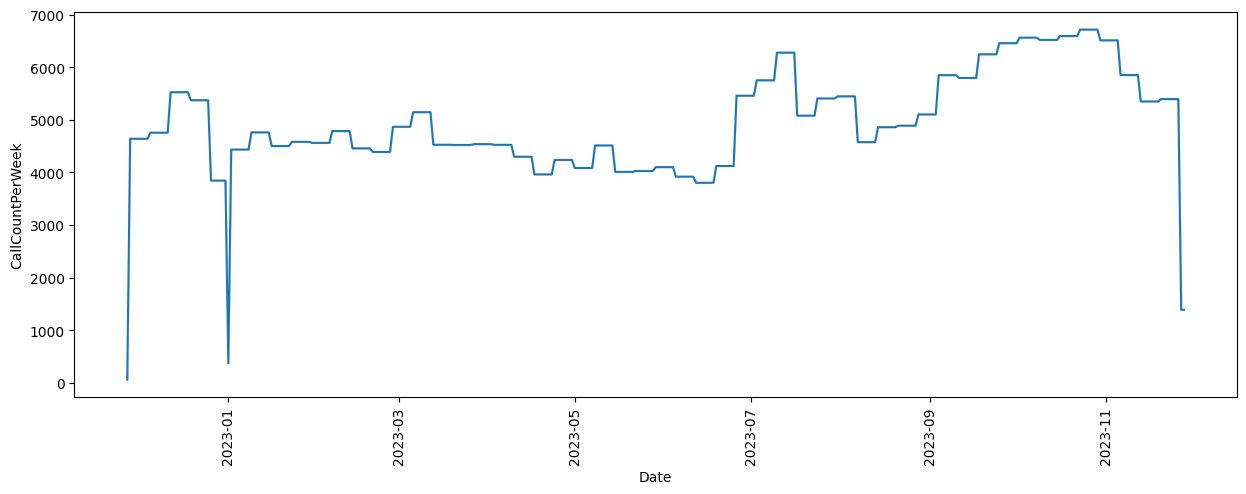

In [105]:
#plot of calls per week
plt.figure(figsize=(15, 5))
sns.lineplot(x='Date', y='CallCountPerWeek', data=f_df)
plt.xticks(rotation=90)
plt.show()


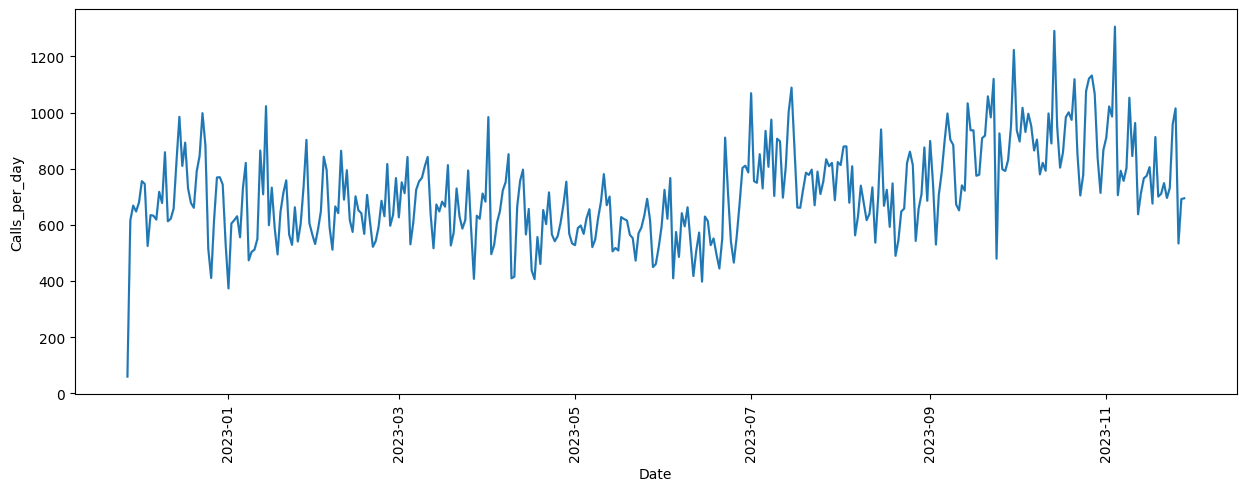

In [106]:
#plot calls_per_day
plt.figure(figsize=(15, 5))
sns.lineplot(x='Date', y='Calls_per_day', data=f_df)
plt.xticks(rotation=90)
plt.show()

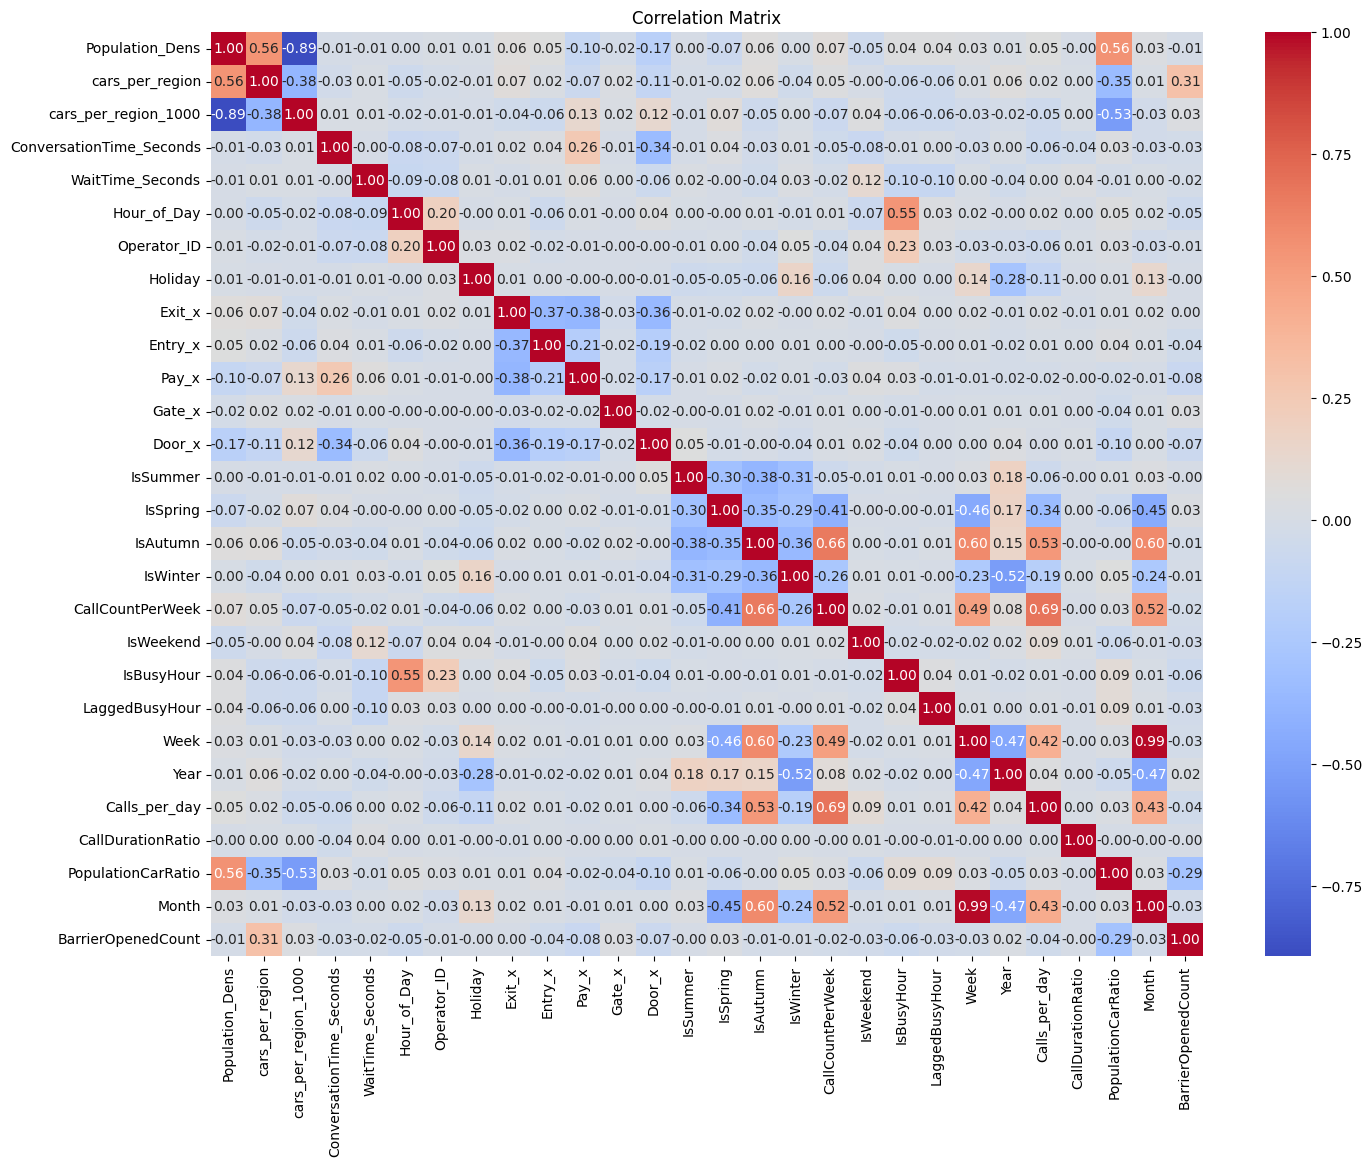

In [107]:

# Calculate the correlation matrix
corr_matrix = f_df[['Population_Dens', 'cars_per_region', 'cars_per_region_1000', 
                    'ConversationTime_Seconds', 'WaitTime_Seconds', 'Hour_of_Day', 
                    'Operator_ID', 'Holiday', 'Exit_x', 'Entry_x', 'Pay_x', 'Gate_x', 
                    'Door_x', 'IsSummer', 'IsSpring', 'IsAutumn', 'IsWinter', 
                    'CallCountPerWeek', 'IsWeekend', 'IsBusyHour', 'LaggedBusyHour', 'Week', 'Year', 'Calls_per_day', 'CallDurationRatio', 'PopulationCarRatio','Month','BarrierOpenedCount']].corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()



In [108]:
#encode calls per day bin and call per week bin
f_df['Calls_per_day_Bin'] = labelencoder.fit_transform(f_df['Calls_per_day_Bin'])
f_df['CallCountPerWeek_Bin'] = labelencoder.fit_transform(f_df['CallCountPerWeek_Bin'])

In [109]:
#now we can select a model based on the distribution of the target variable

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Separate features and target variable
X = f_df.drop(['DateTime', 'Desk', 'WaitTime', 'ConversationTime',
       'Reason', 'Flag_MissedCall', 'Flag_NoCallReceived',
       'ID',
       'Date',
       'Year', 'Operator_ID', 'Device',
       'Calls_per_day', 'Device_1', 'Exit_x', 'Entry_x', 'Pay_x', 'Gate_x', 'Door_x', 'CallCountPerWeek', 'LaggedCallCount',
       'Calls_per_day_Bin', 'CallCountPerWeek_Bin', 'Low_Call_Day_Flag', 'High_Call_Week_Flag','High_Call_Day_Flag','Week','Low_Call_Week_Flag','Month' 
], axis=1) #dropped month column, to avoid introducing biases or incorrect assumptions 
                 # Drop irrelevant columns
y = f_df['High_Call_Week_Flag'] # Set target variable

# Step 2: Splitting the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#decision tree classifier
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, y_train)
y_pred = dt.predict(X_test_scaled)

# Evaluate the model
print('Accuracy score: ', accuracy_score(y_test, y_pred))
print('Precision score: ', precision_score(y_test, y_pred))
print('Recall score: ', recall_score(y_test, y_pred))
print('F1 score: ', f1_score(y_test, y_pred))

# Step 5: Feature Importance
importances = dt.feature_importances_ # Get feature importances
feature_names = X.columns # Get feature names
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False) # Create a DataFrame using a dictionary

print(feature_importance_df)


Accuracy score:  0.7834705702958219
Precision score:  0.7783002370497027
Recall score:  0.7798154421212475
F1 score:  0.7790571028473627
                                Feature  Importance
15                             IsAutumn    0.379281
13                             IsSummer    0.113430
9                      WaitTime_Seconds    0.107991
8              ConversationTime_Seconds    0.101415
20                    CallDurationRatio    0.093436
11                          Hour_of_Day    0.054903
10                          Day_of_Week    0.032020
22                   BarrierOpenedCount    0.022670
24  BarrierOpened_HourOfDay_Interaction    0.020960
1                              Facility    0.017848
23  BarrierOpened_DayOfWeek_Interaction    0.009896
19                       LaggedBusyHour    0.009417
0                                  City    0.008876
17                            IsWeekend    0.004622
14                             IsSpring    0.003778
21                   Population

In [110]:
# Random forest classifier, predicting high call week flag
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Evaluate RF
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC-AUC: {roc_auc}')

# Feature Importance
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

Accuracy: 0.8421584324489173
Precision: 0.8578891082592959
Recall: 0.8120936027722618
F1 Score: 0.8343634363436344
ROC-AUC: 0.8415421152280338
                                Feature  Importance
15                             IsAutumn    0.255384
14                             IsSpring    0.112571
8              ConversationTime_Seconds    0.095121
9                      WaitTime_Seconds    0.094820
20                    CallDurationRatio    0.093733
16                             IsWinter    0.069996
11                          Hour_of_Day    0.056681
13                             IsSummer    0.046727
10                          Day_of_Week    0.033243
1                              Facility    0.028261
22                   BarrierOpenedCount    0.025973
24  BarrierOpened_HourOfDay_Interaction    0.021802
23  BarrierOpened_DayOfWeek_Interaction    0.012477
0                                  City    0.012103
19                       LaggedBusyHour    0.009662
17                       

In [111]:
#rf r model to predict device usage patterns per day of week and facility
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error



# Prepare the features
Y = f_df[['Gate_x', 'Entry_x', 'Exit_x', 'Pay_x', 'Door_x']]

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor with multiple outputs
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, Y_train)

# Predict on test data
Y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred, multioutput='raw_values') #multioutput returns MSE for each output separately
rmse = np.sqrt(mse)



print("Root Mean Squared Error for each device:", rmse)



Root Mean Squared Error for each device: [0.03461944 0.31910991 0.39181852 0.2992187  0.20953145]


In [112]:
#matrix of MSE for each output
print("Mean Squared Error for each device:", mse)

#check feature importance
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

Mean Squared Error for each device: [0.00119851 0.10183113 0.15352175 0.08953183 0.04390343]
                                Feature  Importance
8              ConversationTime_Seconds    0.207494
9                      WaitTime_Seconds    0.114054
20                    CallDurationRatio    0.109756
22                   BarrierOpenedCount    0.109131
11                          Hour_of_Day    0.083328
2                    Flag_BarrierOpened    0.066142
1                              Facility    0.062393
10                          Day_of_Week    0.047859
0                                  City    0.025714
4                       Population_Dens    0.019772
24  BarrierOpened_HourOfDay_Interaction    0.015589
15                             IsAutumn    0.014450
7                  cars_per_region_1000    0.014446
16                             IsWinter    0.013241
19                       LaggedBusyHour    0.012998
13                             IsSummer    0.012741
14                     

In [ ]:
# Dominant Features:

# ConversationTime_Seconds stands out as the most important feature, suggesting that the duration of conversations is a strong predictor of device usage. This could imply that longer interactions lead to more device activations or that device usage drives longer conversations.
# Operational Indicators:

# WaitTime_Seconds and BarrierOpenedCount are also highly influential, indicating that operational metrics (like how long users wait and how often barriers are opened) are critical in predicting device usage.
# Temporal Patterns:

# Hour_of_Day and Day_of_Week play significant roles, highlighting that device usage is not uniform throughout the day or week. Understanding peak times can help in resource allocation and operational planning.

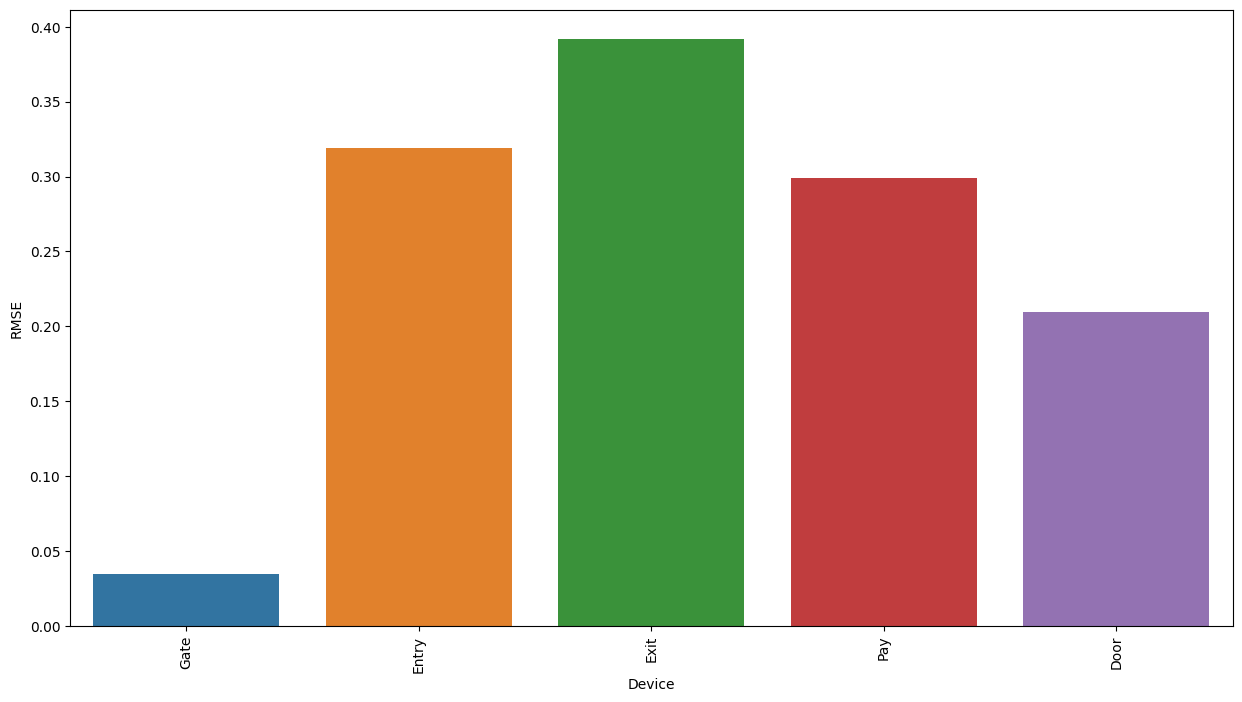

In [113]:
#visualize results of rmse model
plt.figure(figsize=(15, 8))
sns.barplot(x=['Gate', 'Entry', 'Exit', 'Pay', 'Door'], y=rmse)
plt.xticks(rotation=90)
plt.xlabel('Device')
plt.ylabel('RMSE')
plt.show()
